In [2]:
import os
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
import cv2
import numpy as np

# --- 設定 ---
# 生成する動画のフレーム数 (まずは短く設定)
NUM_FRAMES = 30 # 例: 30フレーム (1秒間に15フレームなら2秒の動画)

# 生成画像の解像度 (Stable Diffusion 1.5の推奨サイズ)
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

# 出力ディレクトリ
OUTPUT_DIR = 'small_video_gen_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Stable DiffusionモデルのID (Hugging Face Hubから)
# runwayml/stable-diffusion-v1-5 は広く使われ、比較的軽量です
SD_MODEL_ID = "runwayml/stable-diffusion-v1-5"

# --- 1. Stable Diffusionモデルの準備 ---
def load_diffusion_model(model_id):
    try:
        # GPUが利用可能であればGPUを使用し、torch.float16でメモリを節約
        pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
        # DDIMSchedulerは、より高速なサンプリングを可能にします
        pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
        pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Stable Diffusion model '{model_id}' loaded successfully.")
        return pipe
    except Exception as e:
        print(f"Error loading Stable Diffusion model: {e}")
        print("Please check your internet connection, Hugging Face login (if needed), and GPU setup.")
        return None

# --- 2. プロンプトの定義と変化ロジック ---
def get_frame_prompt(frame_idx, total_frames):
    """
    フレーム番号に基づいてプロンプトを生成します。
    プロンプトを徐々に変化させることで、動きやシーンの変化を表現します。
    """
    # 基本のプロンプト
    base_prompt = "A majestic dragon flying over a fantasy castle at sunset, highly detailed, epic cinematic lighting, volumetric light"
    negative_prompt = "blurry, low resolution, bad anatomy, deformed, ugly, poorly drawn, extra limbs, text"

    # フレーム数に応じた変化（例: 夕焼け -> 夜空、動きの強さ）
    # 0から1の正規化されたタイムステップ
    t = frame_idx / (total_frames - 1) if total_frames > 1 else 0

    # 時間経過で変化する要素
    if t < 0.5:
        # 最初の半分は夕焼けからトワイライトへ
        time_of_day = f"sunset changing to twilight, soft colors, golden hour"
    else:
        # 後半は夜空へ
        time_of_day = f"twilight changing to night sky, stars appearing, moon light"

    # 動きの強調 (プロンプトの重み付けはdiffusersで直接制御できないので、単語で表現)
    movement_intensity = ""
    if t > 0.2 and t < 0.8:
        movement_intensity = "flying gracefully, soaring high,"
    elif t >= 0.8:
        movement_intensity = "landing slowly, descending,"

    full_prompt = f"{base_prompt}, {movement_intensity} {time_of_day}"

    return full_prompt, negative_prompt

# --- 3. 画像フレームの生成 ---
def generate_frames(sd_pipeline, num_frames, width, height):
    print(f"\n--- Generating {num_frames} image frames ---")
    generated_frames_paths = []
    prev_image = None # img2imgのために前のフレームを保持

    for i in range(num_frames):
        prompt, negative_prompt = get_frame_prompt(i, num_frames)
        print(f"Frame {i+1}/{num_frames} - Prompt: {prompt[:80]}...")

        if i == 0:
            # 最初のフレームは text2img で生成
            image = sd_pipeline(
                prompt=prompt,
                negative_prompt=negative_prompt,
                width=width,
                height=height,
                guidance_scale=7.5, # プロンプトへの忠実度
                num_inference_steps=50, # 生成ステップ数
                generator=torch.Generator("cuda").manual_seed(42) # シード固定（実験用）
            ).images[0]
        else:
            # 2フレーム目以降は img2img で前のフレームをベースに生成
            # strength: 0.7-0.8 程度が適切（0で完全なimg2img、1で完全なtext2img）
            # これにより、フレーム間の連続性が高まる
            image = sd_pipeline(
                prompt=prompt,
                negative_prompt=negative_prompt,
                image=prev_image, # 前のフレームを初期画像として使用
                strength=0.75, # 前の画像にどれだけ従うか
                guidance_scale=7.5,
                num_inference_steps=50,
                generator=torch.Generator("cuda").manual_seed(42 + i) # シードを少しずつ変えて変化を出す
            ).images[0]

        frame_path = os.path.join(OUTPUT_DIR, f"frame_{i:04d}.png")
        image.save(frame_path)
        generated_frames_paths.append(frame_path)
        prev_image = image # 次のループのために現在の画像を保存

    print("\n--- Image Frame Generation Complete ---")
    return generated_frames_paths

# --- 4. 画像フレームから動画を作成 ---
def create_video_from_frames(frames_dir, output_video_path, fps=15):
    """
    指定されたディレクトリ内の画像フレームをMP4動画に結合します。
    """
    image_files = sorted(glob.glob(os.path.join(frames_dir, "*.png")))
    if not image_files:
        print("No image frames found to create video.")
        return

    # 最初の画像から動画のサイズを取得
    first_frame = cv2.imread(image_files[0])
    height, width, _ = first_frame.shape

    # VideoWriter オブジェクトの作成 (MP4コーデック)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # mp4v for .mp4 files
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    if not video_writer.isOpened():
        print(f"Error: Could not open video writer for {output_video_path}")
        return

    for image_file in image_files:
        frame = cv2.imread(image_file)
        if frame is not None:
            video_writer.write(frame)
        else:
            print(f"Warning: Could not read frame {image_file}. Skipping.")

    video_writer.release()
    print(f"Video successfully saved to: {output_video_path}")

# --- メイン実行 ---
if __name__ == "__main__":
    # モデルをロード
    diffusion_pipeline = load_diffusion_model(SD_MODEL_ID)
    if diffusion_pipeline is None:
        exit() # モデルロード失敗時は終了

    # 画像フレームを生成
    frame_paths = generate_frames(diffusion_pipeline, NUM_FRAMES, IMAGE_WIDTH, IMAGE_HEIGHT)

    # 生成されたフレームから動画を作成
    output_video_filename = os.path.join(OUTPUT_DIR, "small_fantasy_video.mp4")
    create_video_from_frames(OUTPUT_DIR, output_video_filename)

    print("\nAll done! Check the output directory for your video.")

C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'cv2'

In [12]:
# PyTorchのインストール (GPUを使う場合。CPUのみなら 'pip install torch' でOK)
# NVIDIA CUDA Toolkitのバージョンに合わせてください。例: CUDA 11.8
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

# Stable Diffusionモデルと関連ツール
!pip install diffusers transformers accelerate safetensors

# 画像処理と動画結合
!pip install Pillow
!pip install opencv-python

Looking in indexes: https://download.pytorch.org/whl/cu129


In [13]:
import os
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
import cv2
import numpy as np
import datetime # 日時で出力ディレクトリを作成するため

# --- 設定 ---
# 生成する動画のフレーム数 (短い動画から試す)
NUM_FRAMES = 30 # 15fpsで2秒の動画になります

# 生成画像の解像度 (Stable Diffusion 1.5の標準サイズ)
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

# 1秒あたりのフレーム数 (動画の滑らかさ)
FPS = 15

# 出力ディレクトリ (実行日時でユニークなフォルダを作成)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = f"simple_video_gen_output_{TIMESTAMP}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Stable DiffusionモデルのID (Hugging Face Hubから)
# runwayml/stable-diffusion-v1-5 は広く使われ、比較的軽量です
SD_MODEL_ID = "runwayml/stable-diffusion-v1-5"

# --- 1. Stable Diffusionモデルの準備 ---
def load_diffusion_model(model_id):
    """
    Stable DiffusionモデルをHugging Face Hubからロードします。
    GPUが利用可能であればGPUを使用し、VRAMを節約するためにfloat16を使用します。
    """
    print(f"Loading Stable Diffusion model: {model_id}...")
    try:
        pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
        # DDIMScheduler は、より高速なサンプリングを可能にするスケジューラの一つです
        pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
        pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")
        print("Model loaded successfully to", "GPU" if torch.cuda.is_available() else "CPU")
        return pipe
    except Exception as e:
        print(f"Error loading Stable Diffusion model: {e}")
        print("Please ensure you have internet access, and if using GPU, CUDA is correctly installed.")
        return None

# --- 2. プロンプトの定義と変化ロジック ---
def get_frame_prompt(frame_idx, total_frames):
    """
    フレーム番号に基づいてプロンプトを生成します。
    プロンプトを徐々に変化させることで、簡単な動きやシーンの変化を表現します。
    """
    # 基本のプロンプト。あなたの「ファンタジックな背景」の要望を反映
    base_prompt = "a majestic dragon flying over an ancient fantasy castle, epic cinematic lighting, highly detailed, by Ruan Jia"
    negative_prompt = "blurry, low quality, bad anatomy, deformed, ugly, poorly drawn, extra limbs, text, watermark, signature"

    # 時間の経過を示す変数 (0.0 から 1.0 へ変化)
    t = frame_idx / (total_frames - 1) if total_frames > 1 else 0

    # 例: 時間経過で夕焼けから夜空へ変化させる
    # そして、ドラゴンが城に近づいていくような動きを表現
    if t < 0.3:
        time_of_day = "sunset"
        dragon_action = "flying gracefully in the distance"
    elif t < 0.7:
        time_of_day = "twilight"
        dragon_action = "soaring closer, wings spread wide"
    else:
        time_of_day = "night sky with bright stars"
        dragon_action = "landing near the castle, ethereal glow"

    full_prompt = f"{base_prompt}, {dragon_action}, {time_of_day}"

    return full_prompt, negative_prompt

# --- 3. 画像フレームの生成 ---
def generate_frames(sd_pipeline, num_frames, width, height):
    """
    Stable Diffusionモデルを使って、連続する画像フレームを生成します。
    """
    print(f"\n--- Generating {num_frames} image frames into '{OUTPUT_DIR}' ---")
    generated_frame_paths = []
    prev_image = None # img2imgのために前のフレーム画像を保持

    # 乱数シードを固定することで、同じ設定で毎回同じ結果が得られます（デバッグに便利）
    # 動きに少しバリエーションを持たせたい場合は、iに応じてシードを変えることも可能
    base_seed = 42

    for i in range(num_frames):
        prompt, negative_prompt = get_frame_prompt(i, num_frames)
        print(f"  Frame {i+1}/{num_frames}: Prompt for frame {i} - '{prompt[:100]}...'")

        # generator でシードを制御
        generator = torch.Generator("cuda" if torch.cuda.is_available() else "cpu").manual_seed(base_seed + i)

        if i == 0:
            # 最初のフレームは text2img (テキストから画像生成)
            image = sd_pipeline(
                prompt=prompt,
                negative_prompt=negative_prompt,
                width=width,
                height=height,
                guidance_scale=7.5, # プロンプトへの忠実度
                num_inference_steps=50, # 推論ステップ数（品質と生成速度のトレードオフ）
                generator=generator
            ).images[0]
        else:
            # 2フレーム目以降は img2img (画像から画像生成)
            # 前のフレームをベースに生成することで、連続性が生まれます
            # strength: 0.7-0.8 程度が目安。0に近いほど元の画像に忠実、1に近いほどプロンプトの影響が強い
            image = sd_pipeline(
                prompt=prompt,
                negative_prompt=negative_prompt,
                image=prev_image, # 前のフレームを初期画像として使用
                strength=0.75, # 前の画像からどの程度変化させるか
                guidance_scale=7.5,
                num_inference_steps=50,
                generator=generator
            ).images[0]

        # 生成された画像を保存
        frame_path = os.path.join(OUTPUT_DIR, f"frame_{i:04d}.png")
        image.save(frame_path)
        generated_frame_paths.append(frame_path)
        prev_image = image # 次のループのために現在の画像を保存

    print("\n--- Image Frame Generation Complete ---")
    return generated_frame_paths

# --- 4. 画像フレームから動画を作成 ---
def create_video_from_frames(frames_dir, output_video_path, fps):
    """
    指定されたディレクトリ内の連番画像ファイルをMP4動画に結合します。
    """
    print(f"--- Creating video from frames in '{frames_dir}' ---")
    image_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.png')])
    
    if not image_files:
        print("Error: No image frames found to create video. Please check the output directory.")
        return

    # 最初の画像から動画のサイズを取得
    first_frame = cv2.imread(image_files[0])
    if first_frame is None:
        print(f"Error: Could not read the first frame '{image_files[0]}'.")
        return
    height, width, _ = first_frame.shape

    # VideoWriter オブジェクトの作成 (MP4コーデックを使用)
    # 'mp4v' は多くのシステムで動作するコーデックです
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    if not video_writer.isOpened():
        print(f"Error: Could not open video writer for {output_video_path}. Check permissions or codec availability.")
        return

    for image_file in image_files:
        frame = cv2.imread(image_file)
        if frame is not None:
            video_writer.write(frame)
        else:
            print(f"Warning: Could not read frame {image_file}. Skipping this frame.")

    video_writer.release()
    print(f"Video successfully saved to: {output_video_path}")

# --- メイン実行 ---
if __name__ == "__main__":
    # 1. Stable Diffusionモデルをロード
    diffusion_pipeline = load_diffusion_model(SD_MODEL_ID)
    if diffusion_pipeline is None:
        exit() # モデルロードに失敗したら終了

    # 2. 画像フレームを生成
    generated_frame_paths = generate_frames(diffusion_pipeline, NUM_FRAMES, IMAGE_WIDTH, IMAGE_HEIGHT)

    # 3. 生成されたフレームから動画を作成
    output_video_filename = os.path.join(OUTPUT_DIR, "simple_fantasy_animation.mp4")
    create_video_from_frames(OUTPUT_DIR, output_video_filename, FPS)

    print("\n--- Simple Video Generation Process Complete ---")
    print(f"Check your generated video and frames in: {os.path.abspath(OUTPUT_DIR)}")

ModuleNotFoundError: No module named 'cv2'

--- 生成されたデータの一部 ---
   時間 (hours)  人数 (people)  金 (moneyk_yen)
0   24.818356     2.581829        2.090380
1   28.060056     1.197324        4.505142
2   34.570359     4.068495        2.040118
3   33.703865     2.845111        4.761044
4   33.316684     3.432700        2.843536
データポイント数: 99
------------------------------
K-Meansクラスタリングを開始します (クラスター数: 3)
--- クラスタリング結果の一部 ---
   時間 (hours)  人数 (people)  金 (moneyk_yen)  cluster
0   24.818356     2.581829        2.090380        2
1   28.060056     1.197324        4.505142        2
2   34.570359     4.068495        2.040118        2
3   33.703865     2.845111        4.761044        2
4   33.316684     3.432700        2.843536        2
------------------------------

--- 各クラスターの中心点 ---
クラスター 0: 時間=108.50, 人数=9.61, 金=32.29
クラスター 1: 時間=235.48, 人数=21.34, 金=130.95
クラスター 2: 時間=28.60, 人数=2.89, 金=2.88
------------------------------


C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDE

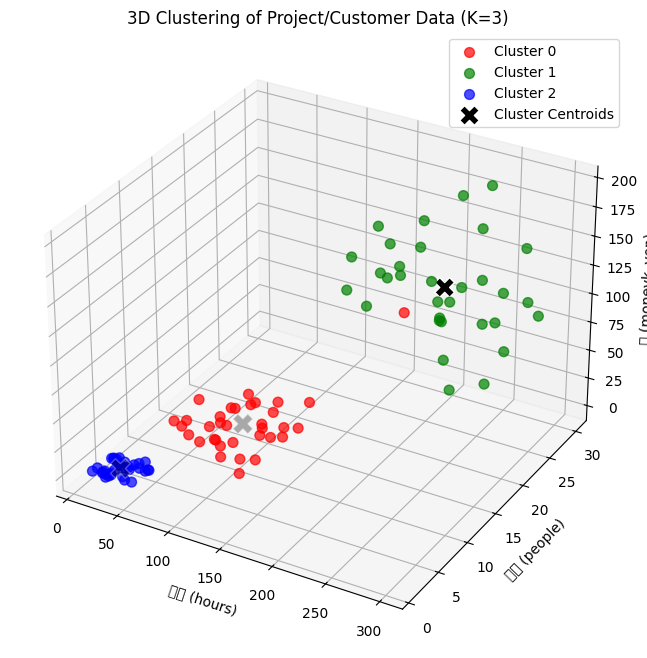


--- 各クラスターの平均値 ---
         時間 (hours)  人数 (people)  金 (moneyk_yen)
cluster                                         
0        108.502905     9.612388       32.293132
1        235.483033    21.336745      130.951301
2         28.600723     2.894419        2.884220
------------------------------

--- 分析の考察例 ---
上記の可視化と平均値から、各クラスターがどのような特性を持つグループなのかを読み解きます。
例えば、
 - クラスター0: 時間、人数、金がすべて低い -> 'ライトユーザー'または'小規模PoCプロジェクト'
 - クラスター1: 時間、人数、金が中程度 -> '標準的な顧客'または'中規模開発プロジェクト'
 - クラスター2: 時間、人数、金が高い -> 'ヘビーユーザー'または'大規模/高価値プロジェクト'

これにより、各グループに合わせたマーケティング戦略やサービス改善策を検討できます。


In [15]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3Dプロット用
import random

# --- 1. データ生成（架空のプロジェクト/顧客データ） ---
# 実際のデータに置き換えてください
# 特徴量:
# '時間' (hours): プロジェクトに費やした時間、または顧客がコンテンツに費やした時間
# '人数' (people): プロジェクトに関わった人数、またはエンゲージしたユニークユーザー数
# '金' (money): プロジェクトに投じた金額、または顧客から得た収益（千円単位など）

# データの数
num_data_points = 100

# データの分布をシミュレート (複数の「群れ」があるようにランダムに生成)
data = []
# 例: 3つの異なる「行動パターン」を持つクラスターを想定
# クラスタ1: 低時間、低人数、低金 (ライトユーザー/小規模プロジェクト)
for _ in range(num_data_points // 3):
    data.append([
        random.uniform(10, 50),   # 時間
        random.uniform(1, 5),     # 人数
        random.uniform(0.5, 5)    # 金 (単位: 千円)
    ])
# クラスタ2: 中時間、中人数、中金 (標準ユーザー/中規模プロジェクト)
for _ in range(num_data_points // 3):
    data.append([
        random.uniform(60, 150),  # 時間
        random.uniform(5, 15),    # 人数
        random.uniform(10, 50)    # 金 (単位: 千円)
    ])
# クラスタ3: 高時間、高人数、高金 (ヘビーユーザー/大規模プロジェクト)
for _ in range(num_data_points // 3):
    data.append([
        random.uniform(160, 300), # 時間
        random.uniform(15, 30),   # 人数
        random.uniform(60, 200)   # 金 (単位: 千円)
    ])

# データフレームに変換
df = pd.DataFrame(data, columns=['時間 (hours)', '人数 (people)', '金 (moneyk_yen)'])

print("--- 生成されたデータの一部 ---")
print(df.head())
print(f"データポイント数: {len(df)}")
print("-" * 30)

# --- 2. クラスタリングの実行 ---

# いくつのクラスターに分けるか (Elbow法などで最適な数を決定しますが、ここでは仮に3とします)
num_clusters = 3
print(f"K-Meansクラスタリングを開始します (クラスター数: {num_clusters})")

# KMeansモデルの初期化と学習
# n_init='auto': 異なる初期値で複数回実行し、最も良い結果を採用
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(df[['時間 (hours)', '人数 (people)', '金 (moneyk_yen)']])

print("--- クラスタリング結果の一部 ---")
print(df.head())
print("-" * 30)

# 各クラスターの中心点
cluster_centers = kmeans.cluster_centers_
print("\n--- 各クラスターの中心点 ---")
for i, center in enumerate(cluster_centers):
    print(f"クラスター {i}: 時間={center[0]:.2f}, 人数={center[1]:.2f}, 金={center[2]:.2f}")
print("-" * 30)

# --- 3. 3次元での可視化 ---

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 各クラスターの色を定義
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k'] # 必要に応じて色を追加

# 各クラスターのデータをプロット
for i in range(num_clusters):
    cluster_data = df[df['cluster'] == i]
    ax.scatter(cluster_data['時間 (hours)'],
               cluster_data['人数 (people)'],
               cluster_data['金 (moneyk_yen)'],
               c=colors[i],
               label=f'Cluster {i}',
               s=50, alpha=0.7)

# クラスターの中心点をプロット (より大きく、異なるマーカーで)
ax.scatter(cluster_centers[:, 0],
           cluster_centers[:, 1],
           cluster_centers[:, 2],
           c='black',
           marker='X',
           s=200,
           label='Cluster Centroids',
           edgecolors='w')

ax.set_xlabel('時間 (hours)')
ax.set_ylabel('人数 (people)')
ax.set_zlabel('金 (moneyk_yen)')
ax.set_title(f'3D Clustering of Project/Customer Data (K={num_clusters})')
ax.legend()
ax.grid(True)
plt.show()

# --- 4. 各クラスターの統計的特徴 (追加分析) ---
print("\n--- 各クラスターの平均値 ---")
print(df.groupby('cluster').mean())
print("-" * 30)

print("\n--- 分析の考察例 ---")
print("上記の可視化と平均値から、各クラスターがどのような特性を持つグループなのかを読み解きます。")
print("例えば、")
print(" - クラスター0: 時間、人数、金がすべて低い -> 'ライトユーザー'または'小規模PoCプロジェクト'")
print(" - クラスター1: 時間、人数、金が中程度 -> '標準的な顧客'または'中規模開発プロジェクト'")
print(" - クラスター2: 時間、人数、金が高い -> 'ヘビーユーザー'または'大規模/高価値プロジェクト'")
print("\nこれにより、各グループに合わせたマーケティング戦略やサービス改善策を検討できます。")

In [17]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # 特徴量の標準化
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# --- 1. データ生成（架空の動画エンゲージメントデータ） ---
# 各データポイントは特定の生成動画、またはそれを見たユーザーグループを表す
num_data_points = 150 # データポイント数を増やしてみる

data = []
for _ in range(num_data_points):
    # 承認欲求関連の特徴量 (仮に0-100でスコア化)
    likes_per_view = random.uniform(0.1, 5.0) # 視聴あたりのいいね数
    comments_per_view = random.uniform(0.01, 0.5) # 視聴あたりのコメント数
    shares_per_view = random.uniform(0.001, 0.1) # 視聴あたりのシェア数
    # これらを組み合わせて「承認欲求スコア」とする
    validation_score = (likes_per_view * 10 + comments_per_view * 50 + shares_per_view * 100) / 100

    # 認知欲・好奇心関連の特徴量 (仮に0-100でスコア化)
    avg_watch_time_ratio = random.uniform(0.2, 0.9) # 平均視聴時間の割合
    external_link_clicks = random.uniform(0, 10) # 外部リンククリック数
    # これらを組み合わせて「認知欲スコア」とする
    cognition_score = (avg_watch_time_ratio * 70 + external_link_clicks * 3) / 100

    # 共感関連の特徴量 (仮に0-100でスコア化)
    empathy_comments = random.uniform(0, 20) # 共感を示すコメント数
    emotional_face_ratio = random.uniform(0.05, 0.8) # 視聴中の感情的な表情の割合
    # これらを組み合わせて「共感スコア」とする
    empathy_score = (empathy_comments * 2 + emotional_face_ratio * 80) / 100

    # 各スコアにノイズを加える、または意図的にクラスターを形成
    # 例として、3つの異なる心理的プロファイルを持つユーザーをシミュレート
    cluster_type = random.randint(0, 2)
    if cluster_type == 0: # 承認欲求型 (SNSでバズりたい)
        validation_score += random.uniform(30, 60)
        cognition_score += random.uniform(-10, 10)
        empathy_score += random.uniform(-10, 10)
    elif cluster_type == 1: # 認知欲型 (深く学びたい、探索したい)
        validation_score += random.uniform(-10, 10)
        cognition_score += random.uniform(30, 60)
        empathy_score += random.uniform(-10, 10)
    else: # 共感型 (ストーリーや感情に強く反応)
        validation_score += random.uniform(-10, 10)
        cognition_score += random.uniform(-10, 10)
        empathy_score += random.uniform(30, 60)
    
    # スコアが0-100の範囲に収まるようにクリッピング
    validation_score = max(0, min(100, validation_score))
    cognition_score = max(0, min(100, cognition_score))
    empathy_score = max(0, min(100, empathy_score))

    data.append([validation_score, cognition_score, empathy_score])

# データフレームに変換
df = pd.DataFrame(data, columns=['承認欲求スコア', '認知欲スコア', '共感スコア'])

print("--- 生成されたデータの一部 ---")
print(df.head())
print(f"データポイント数: {len(df)}")
print("-" * 30)

# --- 2. 特徴量の標準化 ---
# K-Meansは特徴量のスケールに敏感なため、標準化が推奨されます
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[['承認欲求スコア', '認知欲スコア', '共感スコア']])
df_scaled = pd.DataFrame(features_scaled, columns=['承認欲求スコア_scaled', '認知欲スコア_scaled', '共感スコア_scaled'])
print("--- 標準化されたデータの一部 ---")
print(df_scaled.head())
print("-" * 30)

# --- 3. クラスタリングの実行 ---

num_clusters = 3 # 心理的プロファイルを3つに分ける想定
print(f"K-Meansクラスタリングを開始します (クラスター数: {num_clusters})")

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(df_scaled) # 標準化されたデータ

--- 生成されたデータの一部 ---
     承認欲求スコア     認知欲スコア      共感スコア
0   0.000000   0.000000  52.431140
1   9.694316  39.694112   9.584170
2   0.000000   0.000000  32.977397
3  46.569317   0.000000   8.508606
4   5.828955  35.890071   6.452903
データポイント数: 150
------------------------------
--- 標準化されたデータの一部 ---
   承認欲求スコア_scaled  認知欲スコア_scaled  共感スコア_scaled
0       -0.810702      -0.797581      1.626157
1       -0.368829       1.097382     -0.359760
2       -0.810702      -0.797581      0.724494
3        1.311956      -0.797581     -0.409611
4       -0.545015       0.915780     -0.504891
------------------------------
K-Meansクラスタリングを開始します (クラスター数: 3)


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm # Jupyter環境向け

# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

# --- 1. データ準備（架空のデータセット） ---
# 実際のデータはSNSのAPI、動画生成ログ、ユーザーアンケートなどから収集
# ここでは、簡略化のためダミーデータを生成

num_samples = 1000

data = {
    'prompt_text': [
        "A majestic dragon flying over a fantasy castle, epic cinematic lighting.",
        "A cute baby unicorn in a magical forest, very adorable.",
        "Last chance! Epic battle between ancient titans.",
        "Join 10,000 heroes! Unleash your inner warrior.",
        "Don't miss out! Exclusive fiery phoenix animation.",
        "A serene elf meditating by a glowing river, peaceful atmosphere.",
        "Detailed explanation of dragon anatomy in the realm of Eldoria.",
        "How to train your griffin: A step-by-step guide.",
        "Stunning ice dragon amidst a snowy mountain range, breathtaking visuals.",
        "See what happens when light meets shadow: A magical duel.",
    ] * (num_samples // 10), # プロンプトテキスト
    'scarcity_score': np.random.rand(num_samples) * 0.3 + np.random.choice([0.1, 0.9], num_samples, p=[0.7, 0.3]), # 0-1のスコア
    'anchoring_score': np.random.rand(num_samples) * 0.3 + np.random.choice([0.1, 0.9], num_samples, p=[0.7, 0.3]),
    'social_proof_score': np.random.rand(num_samples) * 0.3 + np.random.choice([0.1, 0.9], num_samples, p=[0.7, 0.3]),
    'loss_aversion_score': np.random.rand(num_samples) * 0.3 + np.random.choice([0.1, 0.9], num_samples, p=[0.7, 0.3]),
    'video_duration_sec': np.random.randint(5, 15, num_samples), # 5-15秒
    'ai_params_json': [f'{{"lora_weight": {np.random.rand():.2f}, "guidance": {np.random.rand()*10:.1f}}}' for _ in range(num_samples)],
    'platform': np.random.choice(['Twitter', 'TikTok', 'Instagram'], num_samples),
    'engagement_class': np.random.choice(['Low', 'Medium', 'High'], num_samples, p=[0.4, 0.3, 0.3]) # 予測ターゲット
}
df = pd.DataFrame(data)

# 'High'エンゲージメントのデータポイントを意図的に増やす (不均衡のシミュレーション)
high_engagement_df = df[df['engagement_class'] == 'High'].sample(n=num_samples//5, replace=True, random_state=42)
df = pd.concat([df, high_engagement_df]).reset_index(drop=True)
num_samples = len(df) # データ数を更新

print("--- データセットの概要 ---")
print(df.head())
print(df['engagement_class'].value_counts())
print("-" * 30)

# --- 2. データの前処理 ---

# ターゲット変数を数値にエンコード
label_encoder = LabelEncoder()
df['engagement_label'] = label_encoder.fit_transform(df['engagement_class'])
num_labels = len(label_encoder.classes_)
print(f"エンゲージメントクラス: {label_encoder.classes_} -> 数値エンコード: {label_encoder.transform(label_encoder.classes_)}")

# テキストと数値特徴量の分離
texts = df['prompt_text'].tolist()
numerical_features = df[['scarcity_score', 'anchoring_score', 'social_proof_score', 'loss_aversion_score', 'video_duration_sec']].values
categorical_features = df[['platform']].values

# 数値特徴量の標準化
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

# カテゴリカル特徴量のワンホットエンコーディング (今回は手動で簡略化)
platform_map = {'Twitter': 0, 'TikTok': 1, 'Instagram': 2}
categorical_features_encoded = np.array([platform_map[p[0]] for p in categorical_features]).reshape(-1, 1)

# 全特徴量の結合 (BERTの入力に追加するため、数値・カテゴリカル特徴量は後でテンソルとして渡す)
# ここではテキストをBERTに、数値・カテゴリカルを別途モデルに渡すことを想定
labels = df['engagement_label'].values

# 学習・検証・テストデータに分割
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3, random_state=42, stratify=labels)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

train_num_features, temp_num_features = train_test_split(numerical_features_scaled, test_size=0.3, random_state=42, stratify=labels)
val_num_features, test_num_features = train_test_split(temp_num_features, test_size=0.5, random_state=42, stratify=temp_labels)

train_cat_features, temp_cat_features = train_test_split(categorical_features_encoded, test_size=0.3, random_state=42, stratify=labels)
val_cat_features, test_cat_features = train_test_split(temp_cat_features, test_size=0.5, random_state=42, stratify=temp_labels)

print(f"学習データ数: {len(train_texts)}, 検証データ数: {len(val_texts)}, テストデータ数: {len(test_texts)}")
print("-" * 30)

# --- 3. BERTモデルの準備 ---

# トークナイザーとモデルのロード
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# BertForSequenceClassificationは、分類タスク向けにBERTの出力層に分類ヘッドが付いている
# num_labels: 予測したいクラスの数 (Low, Medium, High の3つ)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)

# BERTの入力をトークン化
def tokenize_texts(tokenizer, texts, max_len=128):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

train_encodings = tokenize_texts(tokenizer, train_texts)
val_encodings = tokenize_texts(tokenizer, val_texts)
test_encodings = tokenize_texts(tokenizer, test_texts)

# 数値・カテゴリカル特徴量をPyTorchテンソルに変換
train_num_features_tensor = torch.tensor(train_num_features, dtype=torch.float32).to(device)
val_num_features_tensor = torch.tensor(val_num_features, dtype=torch.float32).to(device)
test_num_features_tensor = torch.tensor(test_num_features, dtype=torch.float32).to(device)

train_cat_features_tensor = torch.tensor(train_cat_features, dtype=torch.long).to(device) # カテゴリカルはLong
val_cat_features_tensor = torch.tensor(val_cat_features, dtype=torch.long).to(device)
test_cat_features_tensor = torch.tensor(test_cat_features, dtype=torch.long).to(device)


# PyTorch DatasetとDataLoaderの作成
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'],
                              train_num_features_tensor, train_cat_features_tensor, torch.tensor(train_labels, dtype=torch.long))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'],
                            val_num_features_tensor, val_cat_features_tensor, torch.tensor(val_labels, dtype=torch.long))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'],
                             test_num_features_tensor, test_cat_features_tensor, torch.tensor(test_labels, dtype=torch.long))

batch_size = 16 # ハイパーパラメータ
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# --- 4. BERTモデルの出力に数値・カテゴリカル特徴量を組み込むカスタムモデル ---
# BertForSequenceClassificationはテキストのみを扱うため、カスタムクラスを定義
class CustomBertForClassification(torch.nn.Module):
    def __init__(self, bert_model, num_numerical_features, num_categorical_features, num_platform_categories, num_labels):
        super(CustomBertForClassification, self).__init__()
        self.bert = bert_model
        # BERTの隠れ層の出力サイズ (bert-base-uncasedは768)
        bert_hidden_size = bert_model.config.hidden_size

        # 数値特徴量を処理する層
        self.numerical_dense = torch.nn.Linear(num_numerical_features, bert_hidden_size // 2)

        # カテゴリカル特徴量を処理する層 (embeddingを使う場合)
        # 今回はプラットフォームが1つだけなので、直接線形層に渡すことも可能だが、Embeddingを推奨
        self.platform_embedding = torch.nn.Embedding(num_platform_categories, bert_hidden_size // 4)

        # 全ての情報を結合して最終的な分類を行う層
        # BERTの出力 (プールされたCLSトークン) + 数値特徴量処理後の出力 + カテゴリカル特徴量処理後の出力
        combined_feature_size = bert_hidden_size + (bert_hidden_size // 2) + (bert_hidden_size // 4)
        self.classifier = torch.nn.Linear(combined_feature_size, num_labels)

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # CLSトークンの埋め込み (シーケンス全体の表現)
        pooled_output = bert_outputs.pooler_output

        # 数値特徴量を処理
        numerical_output = self.numerical_dense(numerical_features)
        
        # カテゴリカル特徴量を処理
        categorical_output = self.platform_embedding(categorical_features.squeeze(1)) # .squeeze(1)で次元を調整

        # 全ての出力を結合
        combined_features = torch.cat((pooled_output, numerical_output, categorical_output), dim=1)

        # 最終的な分類
        logits = self.classifier(combined_features)
        return logits

# カスタムモデルのインスタンス化
num_numerical_features = numerical_features_scaled.shape[1] # 例: 4つ
num_categorical_features = categorical_features_encoded.shape[1] # 例: 1つ (プラットフォーム)
num_platform_categories = len(platform_map) # 3種類

custom_model = CustomBertForClassification(model.bert, num_numerical_features, num_categorical_features, num_platform_categories, num_labels)
# BERTの分類ヘッドは使わないので、そのパラメータは更新しないようにすることも可能だが、今回はシンプルに全て学習
# カスタムモデル全体をGPUへ
custom_model.to(device)

# --- 5. 学習設定 ---

optimizer = AdamW(custom_model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss() # 分類問題なのでCrossEntropyLoss

epochs = 3 # エポック数 (最初は少なく)

# --- 6. 学習ループ ---
print("\n--- モデル学習開始 ---")
for epoch in range(epochs):
    custom_model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training"):
        input_ids, attention_mask, num_feats, cat_feats, labels = [b.to(device) for b in batch]

        custom_model.zero_grad() # 勾配をリセット

        logits = custom_model(input_ids, attention_mask, num_feats, cat_feats)
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        loss.backward() # 誤差逆伝播
        torch.nn.utils.clip_grad_norm_(custom_model.parameters(), 1.0) # 勾配クリッピング (安定化のため)
        optimizer.step() # パラメータ更新

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Average training loss: {avg_train_loss:.4f}")

    # --- 検証フェーズ ---
    custom_model.eval()
    val_preds = []
    val_true = []
    val_loss = 0
    for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation"):
        input_ids, attention_mask, num_feats, cat_feats, labels = [b.to(device) for b in batch]
        with torch.no_grad(): # 勾配計算を無効化
            logits = custom_model(input_ids, attention_mask, num_feats, cat_feats)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_true, val_preds)
    val_f1 = f1_score(val_true, val_preds, average='weighted') # クラス不均衡を考慮してweighted F1
    
    print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {val_f1:.4f}")
print("\n--- モデル学習完了 ---")


# --- 7. モデル評価 ---
print("\n--- テストデータでの最終評価 ---")
custom_model.eval()
test_preds = []
test_true = []
for batch in tqdm(test_dataloader, desc="Test Evaluation"):
    input_ids, attention_mask, num_feats, cat_feats, labels = [b.to(device) for b in batch]
    with torch.no_grad():
        logits = custom_model(input_ids, attention_mask, num_feats, cat_feats)
    
    preds = torch.argmax(logits, dim=1).flatten()
    test_preds.extend(preds.cpu().numpy())
    test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
test_f1 = f1_score(test_true, test_preds, average='weighted')

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score (weighted): {test_f1:.4f}")
print("\n--- 分類レポート ---")
print(classification_report(test_true, test_preds, target_names=label_encoder.classes_))

# --- 8. モデルの保存 (必要であれば) ---
# torch.save(custom_model.state_dict(), 'marketing_bert_model.pth')
# print("\nモデルを 'marketing_bert_model.pth' に保存しました。")

print("\n--- 評価目標の確認 ---")
target_f1 = 0.8
target_accuracy = 0.85
if test_f1 >= target_f1 and test_accuracy >= target_accuracy:
    print(f"✅ モデルはF1スコア {target_f1:.2f} とAccuracy {target_accuracy:.2f} の目標をクリアしました！")
else:
    print(f"❌ モデルはF1スコア {target_f1:.2f} またはAccuracy {target_accuracy:.2f} の目標をクリアできませんでした。")
    print(f"  F1-Score: {test_f1:.4f} (目標: {target_f1:.2f})")
    print(f"  Accuracy: {test_accuracy:.4f} (目標: {target_accuracy:.2f})")
    print("データ、特徴量、ハイパーパラメータ、モデルアーキテクチャのさらなる改善が必要です。")

Using CPU
--- データセットの概要 ---
                                         prompt_text  scarcity_score  \
0  A majestic dragon flying over a fantasy castle...        0.113723   
1  A cute baby unicorn in a magical forest, very ...        0.974161   
2   Last chance! Epic battle between ancient titans.        0.265918   
3    Join 10,000 heroes! Unleash your inner warrior.        0.955618   
4  Don't miss out! Exclusive fiery phoenix animat...        0.121991   

   anchoring_score  social_proof_score  loss_aversion_score  \
0         0.241666            0.284406             0.150955   
1         0.264217            0.924872             0.190502   
2         1.043475            0.392037             1.140799   
3         0.185251            0.259242             1.191060   
4         0.150177            0.289622             1.096295   

   video_duration_sec                          ai_params_json   platform  \
0                   7  {"lora_weight": 0.48, "guidance": 1.1}    Twitter   
1       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



--- モデル学習開始 ---


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [21]:
pip install --upgrade jupyter ipywidgets

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------------------- ------ 1.8/2.2 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 8.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   --------- ------------------------------ 2.9/12.3 MB 14.0 MB/s eta 0:00:01
   ----------------- ---------------------- 5.5/12.3 MB 12.9 MB/s eta 0:00:01
   -------------------------- ------------- 8.1/12.3 MB 12.9 MB/s eta 0:00:01
   ---------------------------------- ----- 10.7/12.3 MB 12.7 MB/s eta 0:00:01
   ---------------------------------------- 12.3/12.3 MB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ----- ---------------------------------- 2.1/14.3 MB 9.8 MB/s eta 0:00:02
   ----------- ---------------------------- 4.2/14.3 MB 9.7 MB/s eta 0:00:02
   ---------------- ----------------------- 5.8/14.3 MB 9.0 MB/s eta 0:00:01
   -------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
import random

# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

# --- 1. データ準備（架空の認知行動データセット） ---
# 実際のデータはSNSのエンゲージメントログ、ユーザープロファイル、コンテンツ分析結果から収集
num_samples = 2000 # データポイント数を増やす

data = {
    'prompt_text': [
        "A hyper-realistic dragon breathing fire on an ancient, crumbling castle at sunset.", # 認知高め
        "A cute, fluffy baby unicorn napping in a vibrant, magical forest. #癒し #ファンタジー", # 共感高め
        "Limited edition! Only 24 hours to see this exclusive animation of a time-traveling wizard.", # 希少性、損失回避
        "Join the adventure! 1000+ people loved this epic fantasy short. #コミュニティ #仲間", # 社会的証明
        "Mind-bending optical illusion: A floating city of elves that defies physics.", # 好奇心、認知欲
        "What's behind the ancient prophecy? A mysterious figure approaches the sacred monument.", # 好奇心、物語性
        "Relax and escape: A tranquil scene of a waterfall with glowing flora and fauna.", # 逃避
        "Before and after: How a simple prompt transforms into a magnificent creature.", # 認知欲、プロセス
        "Don't waste time! Unlock the secrets of arcane magic now. #効率 #即効性", # 損失回避、クイックウィン
        "The legend says this phantom wolf appears only under the blood moon. #神秘 #伝説", # 希少性、好奇心
        "Share your favorite fantasy creature in the comments!", # 承認欲求、コミュニティ
        "Stunning visuals of a warrior riding a griffin through a lightning storm, cinematic and grand.", # 視覚的斬新さ、高エンゲージメント
        "A peaceful scene of a sleeping dragon, perfect for winding down after work. #リラックス #癒し", # 逃避、仕事終わり
        "Discover the hidden lore of the elemental spirits. Learn something new!", # 認知欲
        "Just uploaded! See the incredible transformation of a mythical beast. Be among the first!", # 承認欲求、新規性
    ] * (num_samples // 15), # 約num_samplesになるように増やす

    # 行動経済学的・心理的特徴量 (0-100のスコアを想定)
    'scarcity_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'anchoring_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'social_proof_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'loss_aversion_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'escape_desire_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'quick_win_satisfaction_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'belonging_community_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'nostalgia_evocation_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'problem_solving_curiosity_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    
    # 時間的投入・消費パターン特徴量 (ダミーデータ)
    'peak_time_engagement_ratio': np.random.rand(num_samples), # 0-1
    'scrolling_speed_score': np.random.rand(num_samples) * 10, # 0-10
    'avg_session_duration_minutes': np.random.rand(num_samples) * 60, # 0-60分
    'night_owl_activity_score': np.random.rand(num_samples) * 5, # 0-5

    # コンテンツ情報処理の好み特徴量 (ダミーデータ)
    'visual_novelty_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'information_density_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'sound_engagement_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'text_complexity_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'pace_change_frequency': np.random.rand(num_samples) * 3, # 0-3 (回/秒)

    # ターゲット変数: 認知レベル (0-4)
    'cognition_level_class': np.random.choice([0, 1, 2, 3, 4], num_samples, p=[0.1, 0.2, 0.3, 0.25, 0.15]) 
}
df = pd.DataFrame(data)

# 実際のデータでは、プロンプトテキストの内容や、ユーザー行動からこれらの特徴量を抽出・計算します
# 例えば、prompt_textに「Limited edition」が含まれるか、「#癒し」が含まれるか、など。
# これは、AI (例えばLLM) によるプロンプト分析や、画像認識AIによる動画内容の分析が関わってきます。

# データセットのサイズを調整して、ランダムにサンプリング (もし数が多すぎる場合)
if len(df) > num_samples:
    df = df.sample(n=num_samples, random_state=42).reset_index(drop=True)

print("--- データセットの概要 ---")
print(df.head())
print(df['cognition_level_class'].value_counts().sort_index())
print("-" * 30)

# --- 2. データの前処理 ---

# ターゲット変数を数値にエンコード (すでに数値なのでそのまま)
label_encoder = LabelEncoder()
df['cognition_level_class_encoded'] = label_encoder.fit_transform(df['cognition_level_class'])
num_labels = len(label_encoder.classes_)
print(f"認知レベルクラス: {label_encoder.classes_} -> 数値エンコード: {label_encoder.transform(label_encoder.classes_)}")

# 特徴量グループの定義
text_features = 'prompt_text'
numerical_features_cols = [
    'scarcity_score', 'anchoring_score', 'social_proof_score', 'loss_aversion_score',
    'escape_desire_score', 'quick_win_satisfaction_score', 'belonging_community_score',
    'nostalgia_evocation_score', 'problem_solving_curiosity_score',
    'peak_time_engagement_ratio', 'scrolling_speed_score', 'avg_session_duration_minutes', 'night_owl_activity_score',
    'visual_novelty_score', 'information_density_score', 'sound_engagement_score', 'text_complexity_score', 'pace_change_frequency'
]

# 数値特徴量の標準化
scaler = StandardScaler()
df[numerical_features_cols] = scaler.fit_transform(df[numerical_features_cols])

# 分割
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['cognition_level_class_encoded'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['cognition_level_class_encoded'])

train_texts = train_df[text_features].tolist()
val_texts = val_df[text_features].tolist()
test_texts = test_df[text_features].tolist()

train_num_features = train_df[numerical_features_cols].values
val_num_features = val_df[numerical_features_cols].values
test_num_features = test_df[numerical_features_cols].values

train_labels = train_df['cognition_level_class_encoded'].values
val_labels = val_df['cognition_level_class_encoded'].values
test_labels = test_df['cognition_level_class_encoded'].values

print(f"学習データ数: {len(train_texts)}, 検証データ数: {len(val_texts)}, テストデータ数: {len(test_texts)}")
print("-" * 30)

# --- 3. BERTモデルの準備とカスタム結合 ---

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model_base = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# 数値特徴量をBERTの出力に結合するカスタムモデル
class MultiModalBertForClassification(torch.nn.Module):
    def __init__(self, bert_base_model, num_numerical_features, num_labels):
        super(MultiModalBertForClassification, self).__init__()
        self.bert = bert_base_model.bert # BERTの本体部分のみを使用
        self.dropout = torch.nn.Dropout(bert_base_model.config.hidden_dropout_prob)
        
        bert_hidden_size = bert_base_model.config.hidden_size # 通常768

        # 数値特徴量をBERTの出力サイズに合わせるための線形層
        self.numerical_projection = torch.nn.Linear(num_numerical_features, bert_hidden_size)
        
        # 最終分類器 (BERTの出力と数値特徴量の結合)
        self.classifier = torch.nn.Linear(bert_hidden_size + bert_hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, numerical_features):
        # BERTのフォワードパス
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output # [CLS]トークンの表現

        # 数値特徴量を処理
        numerical_output = self.numerical_projection(numerical_features)
        
        # BERTの出力と数値特徴量を結合
        combined_features = torch.cat((pooled_output, numerical_output), dim=1)
        combined_features = self.dropout(combined_features)

        # 最終分類器
        logits = self.classifier(combined_features)
        return logits

# カスタムモデルのインスタンス化
num_numerical_features = len(numerical_features_cols)
custom_model = MultiModalBertForClassification(bert_model_base, num_numerical_features, num_labels)
custom_model.to(device)

# トークナイズとテンソル化
def preprocess_data(tokenizer, texts, num_features, labels, max_len=128):
    encodings = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'],
                         torch.tensor(num_features, dtype=torch.float32),
                         torch.tensor(labels, dtype=torch.long))

train_dataset = preprocess_data(tokenizer, train_texts, train_num_features, train_labels)
val_dataset = preprocess_data(tokenizer, val_texts, val_num_features, val_labels)
test_dataset = preprocess_data(tokenizer, test_texts, test_num_features, test_labels)

batch_size = 16 
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# --- 4. 学習設定とループ ---

optimizer = AdamW(custom_model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 3 

print("\n--- モデル学習開始 ---")
for epoch in range(epochs):
    custom_model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training"):
        input_ids, attention_mask, num_feats, labels = [b.to(device) for b in batch]
        
        custom_model.zero_grad()
        logits = custom_model(input_ids, attention_mask, num_feats)
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(custom_model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Average training loss: {avg_train_loss:.4f}")

    # --- 検証フェーズ ---
    custom_model.eval()
    val_preds = []
    val_true = []
    val_loss = 0
    for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation"):
        input_ids, attention_mask, num_feats, labels = [b.to(device) for b in batch]
        with torch.no_grad():
            logits = custom_model(input_ids, attention_mask, num_feats)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_true, val_preds)
    val_f1 = f1_score(val_true, val_preds, average='weighted')
    
    print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {val_f1:.4f}")
print("\n--- モデル学習完了 ---")

# --- 5. モデル評価 ---
print("\n--- テストデータでの最終評価 ---")
custom_model.eval()
test_preds = []
test_true = []
for batch in tqdm(test_dataloader, desc="Test Evaluation"):
    input_ids, attention_mask, num_feats, labels = [b.to(device) for b in batch]
    with torch.no_grad():
        logits = custom_model(input_ids, attention_mask, num_feats)
    
    preds = torch.argmax(logits, dim=1).flatten()
    test_preds.extend(preds.cpu().numpy())
    test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
test_f1 = f1_score(test_true, test_preds, average='weighted')
test_precision = f1_score(test_true, test_preds, average='weighted') # weighted precision
test_recall = f1_score(test_true, test_preds, average='weighted') # weighted recall

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score (weighted): {test_f1:.4f}")
# 個別のクラスのRecall/Precisionを見るには classification_report が便利
print("\n--- 分類レポート ---")
print(classification_report(test_true, test_preds, target_names=label_encoder.classes_))

# --- 6. 評価目標の確認 ---
# 目標設定例: F1スコア0.75以上, Accuracy0.80以上, Acted_UponクラスのRecall0.70以上
target_f1 = 0.75
target_accuracy = 0.80
target_recall_acted_upon = 0.70 # 'Acted_Upon' クラスのインデックスは 4

# classification_reportから個別のクラスのRecallを取得
report = classification_report(test_true, test_preds, target_names=label_encoder.classes_, output_dict=True)
acted_upon_recall = report['4']['recall'] if '4' in report else 0 # '4'はActed_Uponクラスのエンコード値

print("\n--- 評価目標達成状況 ---")
if test_f1 >= target_f1 and test_accuracy >= target_accuracy and acted_upon_recall >= target_recall_acted_upon:
    print(f"✅ モデルはすべての目標をクリアしました！")
    print(f"  F1-Score: {test_f1:.4f} (目標: {target_f1:.2f})")
    print(f"  Accuracy: {test_accuracy:.4f} (目標: {target_accuracy:.2f})")
    print(f"  'Acted_Upon' Recall: {acted_upon_recall:.4f} (目標: {target_recall_acted_upon:.2f})")
else:
    print(f"❌ モデルは一部またはすべての目標をクリアできませんでした。")
    print(f"  F1-Score: {test_f1:.4f} (目標: {target_f1:.2f})")
    print(f"  Accuracy: {test_accuracy:.4f} (目標: {target_accuracy:.2f})")
    print(f"  'Acted_Upon' Recall: {acted_upon_recall:.4f} (目標: {target_recall_acted_upon:.2f})")
    print("データ品質、特徴量エンジニアリング、ハイパーパラメータ、モデルアーキテクチャのさらなる改善が必要です。")

# --- 7. (Optional) Next Step Prediction / Masking の概念 ---
# BERTの学習済みモデルをファインチューニングする際に、
# 本来のNSP (Next Sentence Prediction) や MLM (Masked Language Model) を利用することも可能。
# このコードでは分類タスクとして利用しているが、
# 例えば「あるプロンプトが提示された際に、ユーザーが『Acted_Upon』行動を取るか否か」を
# NSPのように「次のステップがそうなるか」を予測するタスクとして定義することも可能。
# MLMは、例えばプロンプトから特定の行動経済バイアスワードをマスクし、
# それがエンゲージメントにどう影響するかを分析する際に利用できる。
print("\n--- Next Step Prediction (NSP) / Masked Language Model (MLM) の応用概念 ---")
print("このコードは分類タスクですが、BERTのNSP/MLMを直接ファインチューニングする応用も考えられます。")
print("NSP的アプローチ: プロンプトとコンテンツ属性を与え、『その後のユーザー行動（Cognition_Level_Class）が指定のレベルになるか否か』を予測する。")
print("MLM的アプローチ: プロンプトの一部（例: 希少性を示す単語）をマスクし、マスクされた単語を予測させることで、特定のキーワードが動画の魅力にどう寄与するかを分析する。")
print("これらは複雑なカスタム学習ループが必要となるため、まずは分類モデルで基盤を固めることを推奨します。")

Using CPU


ValueError: All arrays must be of the same length

--- 生成されたデータの一部 ---
      承認欲求スコア     認知欲スコア      共感スコア
0   33.834181  61.026387  72.916998
1   67.380479  71.681660  92.958851
2  100.000000  35.126151  26.328003
3   62.863245  62.371827  43.106341
4   39.698935  67.237904  52.804859
データポイント数: 1500
------------------------------
--- 標準化されたデータの一部 ---
   承認欲求スコア_scaled  認知欲スコア_scaled  共感スコア_scaled
0       -1.409187      -0.031766      0.750167
1        0.401028       0.539881      1.663460
2        2.161232      -1.421294     -1.372859
3        0.157270       0.040416     -0.608282
4       -1.092715       0.301477     -0.166328
------------------------------
K-Meansクラスタリングを開始します (クラスター数: 5)


C:\Users\workt\AppData\Local\Temp\ipykernel_8004\3342030516.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_kmeans = plt.cm.get_cmap('tab10', num_clusters_kmeans)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25215 (\N{CJK UNIFIED IDEOGRAPH-627F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35469 (\N{CJK UNIFIED IDEOGRAPH-8A8D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27442 (\N{CJK UNIFIED IDEOGRAPH-6B32}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io,

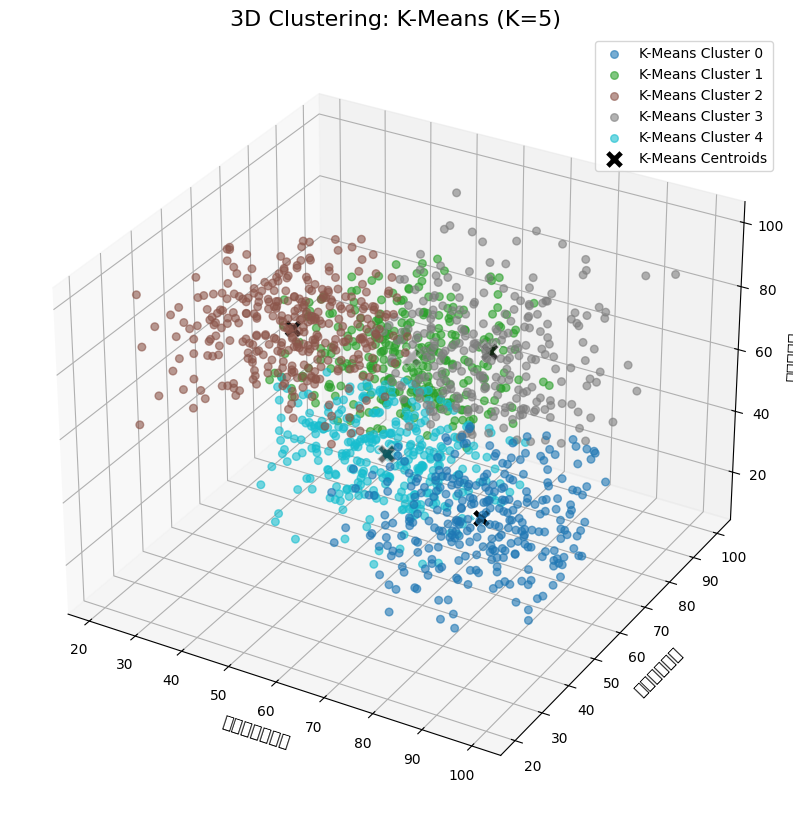


--- K-Means 各クラスターの平均値 (スケール前) ---
                  承認欲求スコア     認知欲スコア      共感スコア
kmeans_cluster                                 
0               85.330702  44.327102  44.012261
1               46.676471  86.820397  46.248283
2               45.796442  45.494266  84.920253
3               72.996921  69.439224  71.790588
4               54.691955  63.634044  35.557051
------------------------------
GMMクラスタリングを開始します (コンポーネント数: 5)


C:\Users\workt\AppData\Local\Temp\ipykernel_8004\3342030516.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_gmm = plt.cm.get_cmap('tab10', num_components_gmm)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25215 (\N{CJK UNIFIED IDEOGRAPH-627F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35469 (\N{CJK UNIFIED IDEOGRAPH-8A8D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27442 (\N{CJK UNIFIED IDEOGRAPH-6B32}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

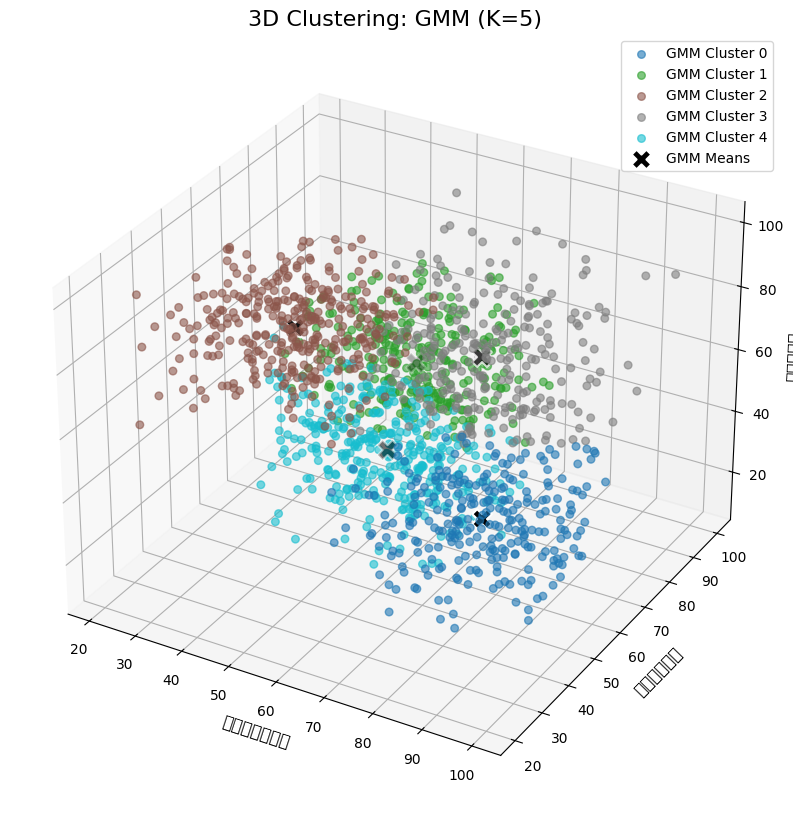


--- GMM 各クラスターの平均値 (スケール前) ---
               承認欲求スコア     認知欲スコア      共感スコア  kmeans_cluster
gmm_cluster                                                 
0            85.996095  43.626752  44.019327        0.000000
1            47.869632  87.478745  45.632368        1.108844
2            46.027692  45.746755  85.153217        2.017699
3            72.995890  69.267504  71.306606        2.859922
4            54.286642  63.241694  35.989988        3.722543
------------------------------

--- K-Means と GMM の比較とビジネスへの示唆 ---
K-Meansは、クラスタを球形（または等方性）と仮定し、各データポイントを最も近い重心に厳密に割り当てます（ハードクラスタリング）。
GMMは、クラスタが複数のガウス分布の混合であると仮定し、より柔軟な形状（楕円形など）のクラスタを検出できます。また、各データポイントがどのクラスターに属するかの確率を提供します（ソフトクラスタリング）。

[今回の結果からの考察]:
GMMの結果は、K-Meansと比較して、クラスター間の境界がより曖昧な場合や、データが重なり合っている領域で、より自然なグルーピングを示す可能性があります。
特に、データ生成時に意図的に設定した各クラスタータイプ（SNSバズり志向型、知識探求・没入型など）が、K-Meansでは硬い境界で分けられるのに対し、GMMではその境界が確率的に表現されます。

[ビジネスへの応用におけるGMMの利点]:
1. **より柔軟なユーザーセグメント**: K-Meansでは捉えきれない、微妙な心理的ニーズの重なりを持つユーザーグループをGMMは検出できる可能性があります。例えば、承認

In [6]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture # GMM用
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# --- 1. データ生成（前回のK-meansと同じデータを使用） ---
num_data_points = 1500

data = []
for _ in range(num_data_points):
    validation_score = random.uniform(20, 80)
    cognition_score = random.uniform(20, 80)
    empathy_score = random.uniform(20, 80)

    cluster_type = random.randint(0, 4) 

    if cluster_type == 0: # 「SNSバズり志向型」
        validation_score = random.uniform(70, 100)
        cognition_score = random.uniform(30, 60)
        empathy_score = random.uniform(30, 60)
    elif cluster_type == 1: # 「知識探求・没入型」
        validation_score = random.uniform(30, 60)
        cognition_score = random.uniform(70, 100)
        empathy_score = random.uniform(30, 60)
    elif cluster_type == 2: # 「感情共鳴型」
        validation_score = random.uniform(30, 60)
        cognition_score = random.uniform(30, 60)
        empathy_score = random.uniform(70, 100)
    elif cluster_type == 3: # 「情報消化型」
        validation_score = random.uniform(40, 70)
        cognition_score = random.uniform(50, 80)
        empathy_score = random.uniform(20, 50)
    else: # cluster_type == 4: 「全般的なエンジョイ型」
        validation_score = random.uniform(50, 90)
        cognition_score = random.uniform(50, 90)
        empathy_score = random.uniform(50, 90)

    validation_score = max(0, min(100, validation_score + random.uniform(-10, 10)))
    cognition_score = max(0, min(100, cognition_score + random.uniform(-10, 10)))
    empathy_score = max(0, min(100, empathy_score + random.uniform(-10, 10)))

    data.append([validation_score, cognition_score, empathy_score])

df = pd.DataFrame(data, columns=['承認欲求スコア', '認知欲スコア', '共感スコア'])

print("--- 生成されたデータの一部 ---")
print(df.head())
print(f"データポイント数: {len(df)}")
print("-" * 30)

# --- 2. 特徴量の標準化 ---
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[['承認欲求スコア', '認知欲スコア', '共感スコア']])
df_scaled = pd.DataFrame(features_scaled, columns=['承認欲求スコア_scaled', '認知欲スコア_scaled', '共感スコア_scaled'])
print("--- 標準化されたデータの一部 ---")
print(df_scaled.head())
print("-" * 30)


# --- 3. K-Means クラスタリングの実行と可視化（比較のため） ---
num_clusters_kmeans = 5 
print(f"K-Meansクラスタリングを開始します (クラスター数: {num_clusters_kmeans})")

kmeans = KMeans(n_clusters=num_clusters_kmeans, random_state=42, n_init='auto')
df['kmeans_cluster'] = kmeans.fit_predict(df_scaled)

cluster_centers_kmeans = df.groupby('kmeans_cluster').mean()

fig_kmeans = plt.figure(figsize=(12, 10))
ax_kmeans = fig_kmeans.add_subplot(111, projection='3d')
colors_kmeans = plt.cm.get_cmap('tab10', num_clusters_kmeans)

for i in range(num_clusters_kmeans):
    cluster_data = df[df['kmeans_cluster'] == i]
    ax_kmeans.scatter(cluster_data['承認欲求スコア'],
                      cluster_data['認知欲スコア'],
                      cluster_data['共感スコア'],
                      color=colors_kmeans(i),
                      label=f'K-Means Cluster {i}',
                      s=30, alpha=0.6)

ax_kmeans.scatter(cluster_centers_kmeans['承認欲求スコア'],
                  cluster_centers_kmeans['認知欲スコア'],
                  cluster_centers_kmeans['共感スコア'],
                  c='black', marker='X', s=200, label='K-Means Centroids', edgecolors='w', linewidths=1.5)

ax_kmeans.set_xlabel('承認欲求スコア', fontsize=12)
ax_kmeans.set_ylabel('認知欲スコア', fontsize=12)
ax_kmeans.set_zlabel('共感スコア', fontsize=12)
ax_kmeans.set_title(f'3D Clustering: K-Means (K={num_clusters_kmeans})', fontsize=16)
ax_kmeans.legend(fontsize=10)
ax_kmeans.grid(True)
plt.show()

print("\n--- K-Means 各クラスターの平均値 (スケール前) ---")
print(cluster_centers_kmeans)
print("-" * 30)


# --- 4. GMM クラスタリングの実行と可視化 ---
# GMMのクラスター数もK-meansと同じく5とします
num_components_gmm = 5 
print(f"GMMクラスタリングを開始します (コンポーネント数: {num_components_gmm})")

# covariance_type: 各ガウス分布の共分散行列の形状を指定
# 'full': 各コンポーネントが独自の一般的な共分散行列を持つ (最も柔軟)
# 'tied': 全てのコンポーネントが同じ共分散行列を共有する
# 'diag': 各コンポーネントが対角共分散行列を持つ (軸に平行な楕円)
# 'spherical': 各コンポーネントが単一の分散を持つ (球状)
# ここでは最も柔軟な 'full' を使用
gmm = GaussianMixture(n_components=num_components_gmm, random_state=42, covariance_type='full')
gmm.fit(features_scaled) # 標準化されたデータで学習
df['gmm_cluster'] = gmm.predict(features_scaled) # 各データポイントを最も確率の高いクラスターに割り当て

# GMMの重心は直接取得できないため、各クラスターの平均値を計算し直す
cluster_centers_gmm = df.groupby('gmm_cluster').mean()

fig_gmm = plt.figure(figsize=(12, 10))
ax_gmm = fig_gmm.add_subplot(111, projection='3d')
colors_gmm = plt.cm.get_cmap('tab10', num_components_gmm)

for i in range(num_components_gmm):
    cluster_data = df[df['gmm_cluster'] == i]
    ax_gmm.scatter(cluster_data['承認欲求スコア'],
                   cluster_data['認知欲スコア'],
                   cluster_data['共感スコア'],
                   color=colors_gmm(i),
                   label=f'GMM Cluster {i}',
                   s=30, alpha=0.6)

# GMMの平均（重心）をプロット
# GMMのmodel.means_は標準化されたデータ上での平均なので、scalerを逆変換して元のスケールに戻す
gmm_means_original_scale = scaler.inverse_transform(gmm.means_)
ax_gmm.scatter(gmm_means_original_scale[:, 0],
               gmm_means_original_scale[:, 1],
               gmm_means_original_scale[:, 2],
               c='black', marker='X', s=200, label='GMM Means', edgecolors='w', linewidths=1.5)

ax_gmm.set_xlabel('承認欲求スコア', fontsize=12)
ax_gmm.set_ylabel('認知欲スコア', fontsize=12)
ax_gmm.set_zlabel('共感スコア', fontsize=12)
ax_gmm.set_title(f'3D Clustering: GMM (K={num_components_gmm})', fontsize=16)
ax_gmm.legend(fontsize=10)
ax_gmm.grid(True)
plt.show()

print("\n--- GMM 各クラスターの平均値 (スケール前) ---")
print(cluster_centers_gmm)
print("-" * 30)

# --- 5. K-MeansとGMMの比較とビジネスへの示唆 ---
print("\n--- K-Means と GMM の比較とビジネスへの示唆 ---")
print("K-Meansは、クラスタを球形（または等方性）と仮定し、各データポイントを最も近い重心に厳密に割り当てます（ハードクラスタリング）。")
print("GMMは、クラスタが複数のガウス分布の混合であると仮定し、より柔軟な形状（楕円形など）のクラスタを検出できます。また、各データポイントがどのクラスターに属するかの確率を提供します（ソフトクラスタリング）。")

print("\n[今回の結果からの考察]:")
print("GMMの結果は、K-Meansと比較して、クラスター間の境界がより曖昧な場合や、データが重なり合っている領域で、より自然なグルーピングを示す可能性があります。")
print("特に、データ生成時に意図的に設定した各クラスタータイプ（SNSバズり志向型、知識探求・没入型など）が、K-Meansでは硬い境界で分けられるのに対し、GMMではその境界が確率的に表現されます。")

print("\n[ビジネスへの応用におけるGMMの利点]:")
print("1. **より柔軟なユーザーセグメント**: K-Meansでは捉えきれない、微妙な心理的ニーズの重なりを持つユーザーグループをGMMは検出できる可能性があります。例えば、承認欲求も高く、同時に共感も求めるようなユーザー層。")
print("2. **ソフトクラスタリングによるパーソナライゼーション**: GMMは各ユーザーが複数のクラスターに属する確率を提示します。例えば、「このユーザーは80%の確率で『知識探求型』だが、20%の確率で『感情共鳴型』でもある」といった情報が得られます。")
print("   - これにより、単一のクラスタリング結果に基づくのではなく、ユーザーの多様な側面を考慮した、よりきめ細やかな動画レコメンデーションやコンテンツ生成が可能になります。")
print("   - 例: ユーザーが「知識探求型」の傾向が強いが「感情共鳴型」の側面も持つ場合、単なる情報提供だけでなく、少し感動的なストーリー要素も加えるといった工夫ができます。")
print("3. **クラスターの重なりの理解**: 特定のマーケティング施策が複数のクラスターにまたがって効果がある場合、GMMの確率的割り当てはそれを理解するのに役立ちます。")

print("\n最終的なモデル選択は、データセットの実際の分布と、ビジネス目標（明確なセグメンテーションが必要か、柔軟なレコメンデーションが必要かなど）によって決定されます。")
print("これらの結果を見て、あなたのビジネスでユーザーの認知をさらに深く理解するためのヒントは見つかりましたか？")

--- データセットの概要 ---
                                         prompt_text  scarcity_score  \
0  A hyper-realistic dragon breathing fire on an ...       48.942210   
1  A cute, fluffy baby unicorn napping in a vibra...       54.020916   
2  Limited edition! Only 24 hours to see this exc...       44.822338   
3  Join the adventure! 1000+ people loved this ep...       38.592157   
4  Mind-bending optical illusion: A floating city...       90.581991   

   anchoring_score  social_proof_score  loss_aversion_score  \
0        58.233394           40.255916            53.063855   
1        38.576072           70.013757            20.339342   
2        46.191679            4.056173            54.511576   
3        76.424029           61.320424            77.222473   
4        37.767776           59.818708             0.000000   

   escape_desire_score  quick_win_satisfaction_score  \
0            76.057649                     55.550505   
1            81.127732                     48.533458   
2 

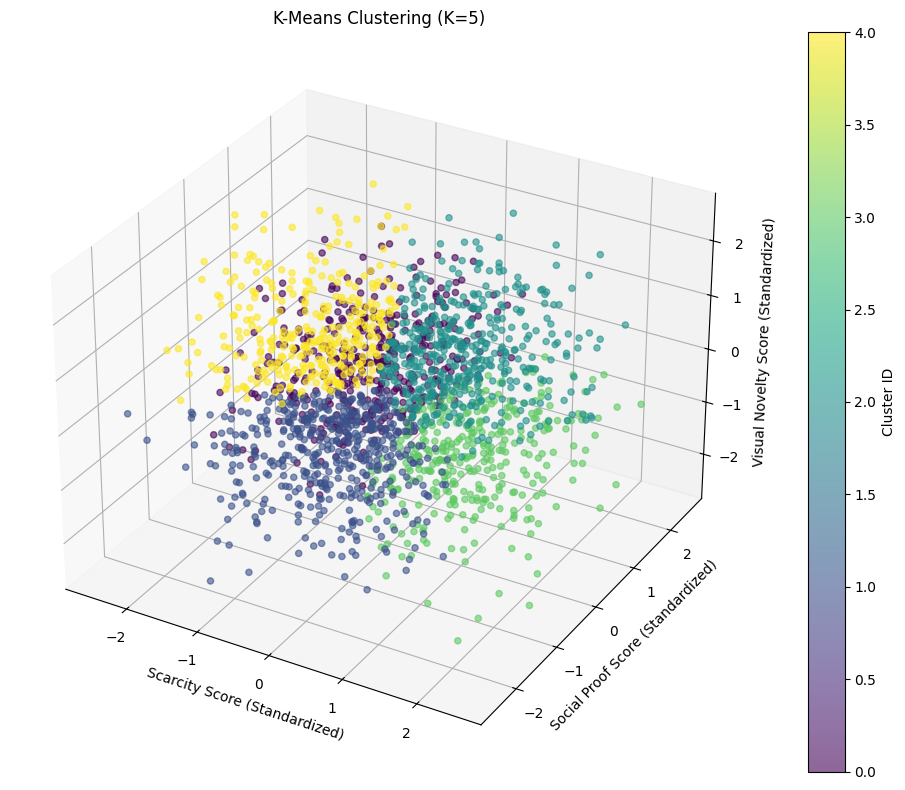

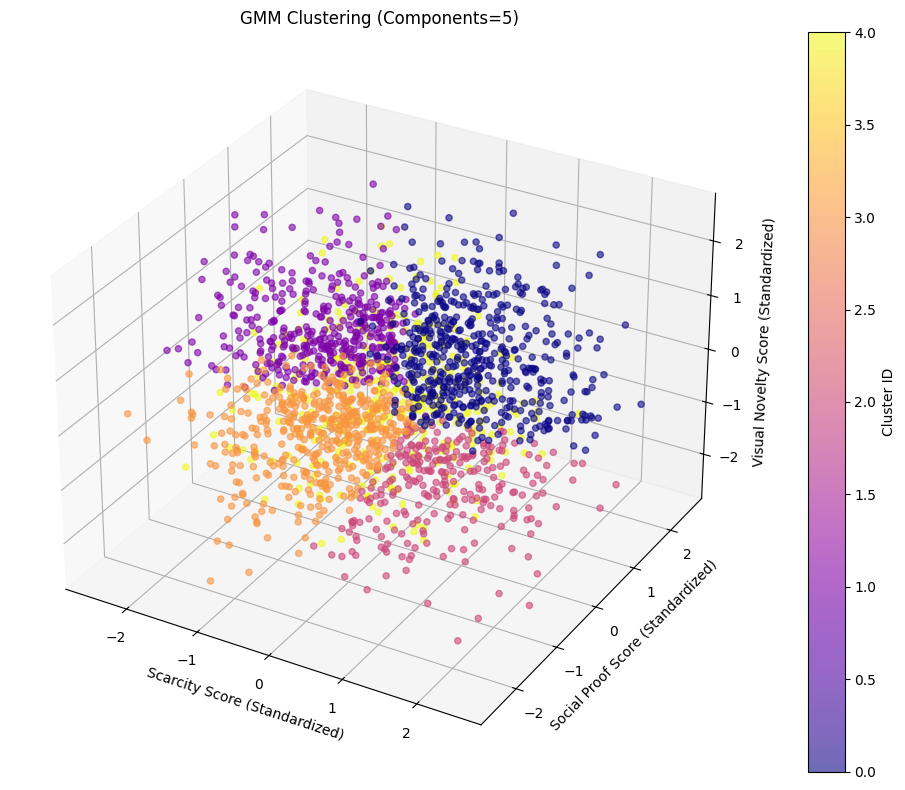


--- クラスタリング完了 ---
K-MeansとGMMによるクラスタリング結果を3D散布図で可視化しました。
選択された特徴量は 'Scarcity Score', 'Social Proof Score', 'Visual Novelty Score' です。


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# --- 1. データ準備（架空の認知行動データセット） ---
# 実際のデータはSNSのエンゲージメントログ、ユーザープロファイル、コンテンツ分析結果から収集
num_samples = 2000 # データポイント数を増やす

# 元のプロンプトテキストのリスト
original_prompts = [
    "A hyper-realistic dragon breathing fire on an ancient, crumbling castle at sunset.", # 認知高め
    "A cute, fluffy baby unicorn napping in a vibrant, magical forest. #癒し #ファンタジー", # 共感高め
    "Limited edition! Only 24 hours to see this exclusive animation of a time-traveling wizard.", # 希少性、損失回避
    "Join the adventure! 1000+ people loved this epic fantasy short. #コミュニティ #仲間", # 社会的証明
    "Mind-bending optical illusion: A floating city of elves that defies physics.", # 好奇心、認知欲
    "What's behind the ancient prophecy? A mysterious figure approaches the sacred monument.", # 好奇心、物語性
    "Relax and escape: A tranquil scene of a waterfall with glowing flora and fauna.", # 逃避
    "Before and after: How a simple prompt transforms into a magnificent creature.", # 認知欲、プロセス
    "Don't waste time! Unlock the secrets of arcane magic now. #効率 #即効性", # 損失回避、クイックウィン
    "The legend says this phantom wolf appears only under the blood moon. #神秘 #伝説", # 希少性、好奇心
    "Share your favorite fantasy creature in the comments!", # 承認欲求、コミュニティ
    "Stunning visuals of a warrior riding a griffin through a lightning storm, cinematic and grand.", # 視覚的斬新さ、高エンゲージメント
    "A peaceful scene of a sleeping dragon, perfect for winding down after work. #リラックス #癒し", # 逃避、仕事終わり
    "Discover the hidden lore of the elemental spirits. Learn something new!", # 認知欲
    "Just uploaded! See the incredible transformation of a mythical beast. Be among the first!", # 承認欲求、新規性
]

# prompt_textのリストを正確にnum_samplesの長さに調整
# オリジナルリストを繰り返し、num_samples分だけ取得します
prompt_texts_extended = (original_prompts * (num_samples // len(original_prompts) + 1))[:num_samples]


data = {
    'prompt_text': prompt_texts_extended, # ここを修正

    # 行動経済学的・心理的特徴量 (0-100のスコアを想定)
    'scarcity_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'anchoring_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'social_proof_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'loss_aversion_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'escape_desire_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'quick_win_satisfaction_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'belonging_community_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'nostalgia_evocation_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'problem_solving_curiosity_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    
    # 時間的投入・消費パターン特徴量 (ダミーデータ)
    'peak_time_engagement_ratio': np.random.rand(num_samples), # 0-1
    'scrolling_speed_score': np.random.rand(num_samples) * 10, # 0-10
    'avg_session_duration_minutes': np.random.rand(num_samples) * 60, # 0-60分
    'night_owl_activity_score': np.random.rand(num_samples) * 5, # 0-5

    # コンテンツ情報処理の好み特徴量 (ダミーデータ)
    'visual_novelty_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'information_density_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'sound_engagement_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'text_complexity_score': np.clip(np.random.normal(50, 20, num_samples), 0, 100),
    'pace_change_frequency': np.random.rand(num_samples) * 3, # 0-3 (回/秒)

    # ターゲット変数: 認知レベル (0-4)
    'cognition_level_class': np.random.choice([0, 1, 2, 3, 4], num_samples, p=[0.1, 0.2, 0.3, 0.25, 0.15])    
}
df = pd.DataFrame(data)

# データセットのサイズを調整して、ランダムにサンプリング (もし数が多すぎる場合)
# この部分は、上記の修正で不要になることが多いですが、念のため残しておきます。
if len(df) > num_samples:
    df = df.sample(n=num_samples, random_state=42).reset_index(drop=True)

print("--- データセットの概要 ---")
print(df.head())
print(df['cognition_level_class'].value_counts().sort_index())
print("-" * 30)

# --- 2. データの前処理 ---

# ターゲット変数を数値にエンコード (すでに数値なのでそのまま)
label_encoder = LabelEncoder()
df['cognition_level_class_encoded'] = label_encoder.fit_transform(df['cognition_level_class'])
num_labels = len(label_encoder.classes_)
print(f"認知レベルクラス: {label_encoder.classes_} -> 数値エンコード: {label_encoder.transform(label_encoder.classes_)}")

# 特徴量グループの定義
text_features = 'prompt_text'
numerical_features_cols = [
    'scarcity_score', 'anchoring_score', 'social_proof_score', 'loss_aversion_score',
    'escape_desire_score', 'quick_win_satisfaction_score', 'belonging_community_score',
    'nostalgia_evocation_score', 'problem_solving_curiosity_score',
    'peak_time_engagement_ratio', 'scrolling_speed_score', 'avg_session_duration_minutes', 'night_owl_activity_score',
    'visual_novelty_score', 'information_density_score', 'sound_engagement_score', 'text_complexity_score', 'pace_change_frequency'
]

# 数値特徴量の標準化
scaler = StandardScaler()
df[numerical_features_cols] = scaler.fit_transform(df[numerical_features_cols])

# クラスタリング用の特徴量を選択 (3Dグラフのため3つ選択)
# ここでは、scarcity_score, social_proof_score, visual_novelty_score を選びます
clustering_features = df[['scarcity_score', 'social_proof_score', 'visual_novelty_score']].values

# --- 3. K-Means クラスタリング ---
# クラスタ数 K を仮定（例えば、認知レベルのクラス数に合わせるか、エルボー法などで決定）
n_clusters_kmeans = 5 
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10) # n_initを明示的に設定
kmeans_labels = kmeans.fit_predict(clustering_features)
df['kmeans_cluster'] = kmeans_labels

print("\n--- K-Means クラスタリング結果 ---")
print(df['kmeans_cluster'].value_counts().sort_index())

# --- 4. GMM クラスタリング ---
# クラスタ数 K を仮定（K-Meansと同じ数で比較）
n_components_gmm = 5
gmm = GaussianMixture(n_components=n_components_gmm, random_state=42)
gmm_labels = gmm.fit_predict(clustering_features)
df['gmm_cluster'] = gmm_labels

print("\n--- GMM クラスタリング結果 ---")
print(df['gmm_cluster'].value_counts().sort_index())

# --- 5. 3D グラフでの可視化 ---

# K-Means クラスタリングの可視化
fig_kmeans = plt.figure(figsize=(12, 8))
ax_kmeans = fig_kmeans.add_subplot(111, projection='3d')
scatter_kmeans = ax_kmeans.scatter(
    clustering_features[:, 0], clustering_features[:, 1], clustering_features[:, 2],
    c=df['kmeans_cluster'], cmap='viridis', s=20, alpha=0.6
)
ax_kmeans.set_xlabel('Scarcity Score (Standardized)')
ax_kmeans.set_ylabel('Social Proof Score (Standardized)')
ax_kmeans.set_zlabel('Visual Novelty Score (Standardized)')
ax_kmeans.set_title(f'K-Means Clustering (K={n_clusters_kmeans})')
fig_kmeans.colorbar(scatter_kmeans, ax=ax_kmeans, label='Cluster ID')
plt.tight_layout()
plt.show()

# GMM クラスタリングの可視化
fig_gmm = plt.figure(figsize=(12, 8))
ax_gmm = fig_gmm.add_subplot(111, projection='3d')
scatter_gmm = ax_gmm.scatter(
    clustering_features[:, 0], clustering_features[:, 1], clustering_features[:, 2],
    c=df['gmm_cluster'], cmap='plasma', s=20, alpha=0.6
)
ax_gmm.set_xlabel('Scarcity Score (Standardized)')
ax_gmm.set_ylabel('Social Proof Score (Standardized)')
ax_gmm.set_zlabel('Visual Novelty Score (Standardized)')
ax_gmm.set_title(f'GMM Clustering (Components={n_components_gmm})')
fig_gmm.colorbar(scatter_gmm, ax=ax_gmm, label='Cluster ID')
plt.tight_layout()
plt.show()

print("\n--- クラスタリング完了 ---")
print("K-MeansとGMMによるクラスタリング結果を3D散布図で可視化しました。")
print("選択された特徴量は 'Scarcity Score', 'Social Proof Score', 'Visual Novelty Score' です。")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, precision_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- 0. 設定とデータ生成の準備 ---
# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

num_users = 2000
num_content_types = 10 # 異なるコンテンツタイプ数
epochs = 5
learning_rate = 2e-5

# ダミーのコンテンツタイプ名
content_type_names = [f"Content_{i+1}: {'癒し系ユニコーン' if i==0 else '壮大なドラゴンバトル' if i==1 else '知識探求ファンタジー' if i==2 else 'サプライズ重視' if i==3 else 'コミュニティ系' if i==4 else 'ノスタルジー系' if i==5 else '損失回避系' if i==6 else 'クイックウィン系' if i==7 else '異世界逃避系' if i==8 else '不明'}" for i in range(num_content_types)]


# --- 1. ユーザー行動データとコンテンツデータの生成 (複雑なシミュレーション) ---
user_data = []
# 最近視聴コンテンツの最大数を定義
max_recent_contents = 3 

for _ in range(num_users):
    # ユーザーの初期心理的傾向 (GMMの入力)
    validation = random.uniform(0, 100)
    cognition = random.uniform(0, 100)
    empathy = random.uniform(0, 100)
    loss_aversion = random.uniform(0, 100)
    scarcity = random.uniform(0, 100)

    # ユーザーの行動履歴（簡略化）
    # 直近のコンテンツ視聴履歴のIDと視聴時間割合
    num_recent = random.randint(0, max_recent_contents) # 0からmax_recent_contents個のコンテンツを視聴
    recent_watched_content = random.sample(range(num_content_types), num_recent)
    recent_watch_ratios = [random.uniform(0.2, 0.9) for _ in recent_watched_content]
    
    # ここがポイント: リストをリストとして追加
    user_data.append([validation, cognition, empathy, loss_aversion, scarcity, 
                       recent_watched_content, recent_watch_ratios])

# データフレームに変換する際に、リストのカラムを直接扱えるようにする
# 各リストのパディングは後で `padded_user_data` を作成するときに行う
df_users_raw = pd.DataFrame(user_data, columns=[
    '承認欲求スコア', '認知欲求スコア', '共感スコア', '損失回避スコア', '希少性スコア',
    'recent_watched_content_ids', 'recent_watch_ratios'
])

# パディング処理
padded_user_data_final = []
for index, row in df_users_raw.iterrows():
    # 心理的スコア
    psych_scores = row[['承認欲求スコア', '認知欲求スコア', '共感スコア', '損失回避スコア', '希少性スコア']].tolist()
    
    # 最近視聴コンテンツIDのパディング (存在しない場合は-1)
    recent_ids = row['recent_watched_content_ids']
    padded_ids = recent_ids + [-1] * (max_recent_contents - len(recent_ids))
    
    # 最近視聴コンテンツ割合のパディング (存在しない場合は0.0)
    recent_ratios = row['recent_watch_ratios']
    padded_ratios = recent_ratios + [0.0] * (max_recent_contents - len(recent_ratios))
    
    padded_user_data_final.append(psych_scores + padded_ids + padded_ratios)

df_users = pd.DataFrame(padded_user_data_final, columns=[
    '承認欲求スコア', '認知欲求スコア', '共感スコア', '損失回避スコア', '希少性スコア',
    '最近視聴C1_ID', '最近視聴C2_ID', '最近視聴C3_ID',
    '最近視聴C1_Ratio', '最近視聴C2_Ratio', '最近視聴C3_Ratio'
])
print("--- ユーザーデータの一部 ---")
print(df_users.head())


# コンテンツデータ（プロンプトと属性）
content_data = []
for i in range(num_content_types):
    prompt = content_type_names[i].replace("Content_", "This content is about ") + ". It features epic fantasy animals."
    duration = random.uniform(30, 120) # seconds
    promo_word_present = random.choice([0, 1]) # 1: プロモーションワードあり
    
    content_data.append([prompt, duration, promo_word_present])

df_content = pd.DataFrame(content_data, columns=['prompt_text', 'duration_sec', 'promo_word_present'])
print("\n--- コンテンツデータの一部 ---")
print(df_content.head())

# --- 2. GMMによるユーザー特性の確率分布抽出 ---
# GMMの入力特徴量（今回はユーザーの心理的スコアを使用）
user_gmm_features = df_users[['承認欲求スコア', '認知欲求スコア', '共感スコア', '損失回避スコア', '希少性スコア']]
scaler_gmm = StandardScaler()
user_gmm_features_scaled = scaler_gmm.fit_transform(user_gmm_features)

num_user_clusters = 5 # ユーザー特性クラスター数
gmm_user = GaussianMixture(n_components=num_user_clusters, random_state=42, covariance_type='full')
gmm_user.fit(user_gmm_features_scaled)

# 各ユーザーが各クラスターに属する確率を取得
user_cluster_probabilities = gmm_user.predict_proba(user_gmm_features_scaled)
print(f"\n--- ユーザーごとのクラスター所属確率の例 (最初の5ユーザー) ---")
print(user_cluster_probabilities[:5])
print(f"形状: {user_cluster_probabilities.shape}")


# --- 3. BERT MUMベースのコンテンツエンコーディングと予測モデル ---
# BERT MUMは概念として、ここでは通常のBERTを使用
# 実際のMUMはより大規模で、事前学習済みモデルが多モダリティ対応
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')

# カスタムのマルチモーダル予測モデル
class MultiModalPredictionModel(nn.Module):
    def __init__(self, bert_model, num_user_clusters, num_numerical_content_features, num_output_types):
        super(MultiModalPredictionModel, self).__init__()
        self.bert = bert_model
        bert_hidden_size = bert_model.config.hidden_size # 768 for bert-base

        # ユーザー確率分布の変換層
        self.user_prob_dense = nn.Linear(num_user_clusters, bert_hidden_size // 4)
        
        # 数値コンテンツ特徴量の変換層 (duration_sec, promo_word_presentなど)
        self.numerical_content_dense = nn.Linear(num_numerical_content_features, bert_hidden_size // 4)

        # 結合された特徴量から最終予測への層
        # BERT出力 + ユーザー確率 + 数値コンテンツ特徴量
        combined_size = bert_hidden_size + (bert_hidden_size // 4) + (bert_hidden_size // 4)
        
        # 購買確率予測 (二値分類 or 多クラス分類)
        self.buy_classifier = nn.Linear(combined_size, 2) # 例: 購買するか否か (0/1)

        # 期待収益額予測 (回帰)
        self.revenue_regressor = nn.Linear(combined_size, 1)

    def forward(self, input_ids, attention_mask, user_probs, numerical_content_features):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output # CLSトークンの表現

        user_prob_output = self.user_prob_dense(user_probs)
        numerical_content_output = self.numerical_content_dense(numerical_content_features)
        
        # 全ての情報を結合
        combined_features = torch.cat((pooled_output, user_prob_output, numerical_content_output), dim=1)

        # 予測
        buy_logits = self.buy_classifier(combined_features)
        revenue_prediction = self.revenue_regressor(combined_features)
        
        return buy_logits, revenue_prediction

# モデルのインスタンス化
num_numerical_content_features = len(['duration_sec', 'promo_word_present'])
model = MultiModalPredictionModel(bert_model, num_user_clusters, num_numerical_content_features, 2)
model.to(device)

# --- 4. 学習データセットの準備 (ユーザーとコンテンツの組み合わせで拡張) ---
# 各ユーザーと各コンテンツタイプの組み合わせに対して、購買/収益データをシミュレーション
train_samples = []
for user_idx in range(num_users):
    user_prob = user_cluster_probabilities[user_idx]
    
    for content_idx in range(num_content_types):
        content_prompt = df_content.loc[content_idx, 'prompt_text']
        content_duration = df_content.loc[content_idx, 'duration_sec']
        content_promo_word = df_content.loc[content_idx, 'promo_word_present']

        # 購買シミュレーション (非常に簡略化されたルール)
        # ユーザー特性とコンテンツタイプが一致すると購買確率が上がる
        # 例: 「知識探求型」ユーザー (GMMクラスター1) は「知識探求ファンタジー」コンテンツ (コンテンツ2) で購買しやすい
        buy_prob_base = 0.1 # 基本購買確率
        expected_revenue_base = 100 # 基本期待収益

        # ユーザーのクラスター確率とコンテンツタイプの関連付け
        # GMMクラスター0 -> Content_1, GMMクラスター1 -> Content_2, ...
        # (実際の関連付けは学習データからモデルが学習する)
        user_main_cluster = np.argmax(user_prob)
        if user_main_cluster == content_idx: # 理想的な一致
            buy_prob_base += 0.5 # 購買確率を大幅アップ
            expected_revenue_base += 500
        elif abs(user_main_cluster - content_idx) == 1: # 近い傾向
            buy_prob_base += 0.2
            expected_revenue_base += 200

        # プロモーションワードの効果
        if content_promo_word == 1:
            buy_prob_base += 0.1
            expected_revenue_base += 100
        
        # 最終的な購買と収益
        is_bought = 1 if random.random() < buy_prob_base else 0
        actual_revenue = expected_revenue_base if is_bought else 0

        train_samples.append({
            'user_idx': user_idx,
            'content_idx': content_idx,
            'prompt_text': content_prompt,
            'user_cluster_probs': user_prob,
            'duration_sec': content_duration,
            'promo_word_present': content_promo_word,
            'is_bought': is_bought,
            'actual_revenue': actual_revenue
        })

df_train = pd.DataFrame(train_samples)
print(f"\n--- 学習データサンプル数: {len(df_train)} ---")
print(df_train.head())

# データセットの分割
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['is_bought'])

# PyTorchデータセットの作成
def create_dataloader(df, tokenizer, batch_size, shuffle=True):
    input_ids = []
    attention_masks = []
    for prompt in df['prompt_text']:
        encoded_dict = tokenizer.encode_plus(
            prompt,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    user_cluster_probs_tensor = torch.tensor(df['user_cluster_probs'].tolist(), dtype=torch.float32)
    numerical_content_features_tensor = torch.tensor(df[['duration_sec', 'promo_word_present']].values, dtype=torch.float32)
    
    is_bought_tensor = torch.tensor(df['is_bought'].values, dtype=torch.long)
    actual_revenue_tensor = torch.tensor(df['actual_revenue'].values, dtype=torch.float32).unsqueeze(1) # 回帰用はunsqueeze(1)で形状調整

    dataset = TensorDataset(input_ids, attention_masks, user_cluster_probs_tensor, 
                            numerical_content_features_tensor, is_bought_tensor, actual_revenue_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = create_dataloader(train_df, tokenizer, batch_size=16, shuffle=True)
val_dataloader = create_dataloader(val_df, tokenizer, batch_size=16, shuffle=False)


# --- 5. 学習ループ ---
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
buy_criterion = nn.CrossEntropyLoss() # 購買予測 (分類)
revenue_criterion = nn.MSELoss() # 収益予測 (回帰)

print("\n--- モデル学習開始 ---")
for epoch in range(epochs):
    model.train()
    total_buy_loss = 0
    total_revenue_loss = 0
    
    for batch in train_dataloader:
        input_ids, attention_mask, user_probs, num_content_feats, is_bought, actual_revenue = [b.to(device) for b in batch]

        optimizer.zero_grad()
        buy_logits, revenue_prediction = model(input_ids, attention_mask, user_probs, num_content_feats)
        
        loss_buy = buy_criterion(buy_logits, is_bought)
        loss_revenue = revenue_criterion(revenue_prediction, actual_revenue)
        
        # マルチタスク学習: 2つの損失を合計して最適化
        total_loss = loss_buy + loss_revenue 
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_buy_loss += loss_buy.item()
        total_revenue_loss += loss_revenue.item()

    avg_buy_loss = total_buy_loss / len(train_dataloader)
    avg_revenue_loss = total_revenue_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}: Avg Buy Loss: {avg_buy_loss:.4f}, Avg Revenue Loss: {avg_revenue_loss:.4f}")

    # --- 検証フェーズ ---
    model.eval()
    val_buy_preds = []
    val_buy_true = []
    val_revenue_preds = []
    val_revenue_true = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, user_probs, num_content_feats, is_bought, actual_revenue = [b.to(device) for b in batch]
            
            buy_logits, revenue_prediction = model(input_ids, attention_mask, user_probs, num_content_feats)
            
            val_buy_preds.extend(torch.argmax(buy_logits, dim=1).cpu().numpy())
            val_buy_true.extend(is_bought.cpu().numpy())
            val_revenue_preds.extend(revenue_prediction.cpu().numpy().flatten())
            val_revenue_true.extend(actual_revenue.cpu().numpy().flatten())

    val_f1 = f1_score(val_buy_true, val_buy_preds, average='weighted')
    val_accuracy = accuracy_score(val_buy_true, val_buy_preds)
    val_rmse = np.sqrt(mean_squared_error(val_revenue_true, val_revenue_preds))

    print(f"  Validation F1: {val_f1:.4f}, Acc: {val_accuracy:.4f}, RMSE: {val_rmse:.2f}")

print("\n--- モデル学習完了 ---")


# --- 6. 最終予測とマーケティング戦略提案 ---
print("\n--- 最適なマーケティング戦略の提案 ---")

# 新しいユーザー（または既存ユーザーの行動変化後）の情報を想定
# 例えば、このユーザーは「知識探求」傾向が強く、最近は「癒し系」コンテンツも見てる、と仮定
new_user_gmm_input = np.array([[random.uniform(30,50), random.uniform(80,100), random.uniform(40,60), random.uniform(50,70), random.uniform(30,50)]])
new_user_gmm_input_scaled = scaler_gmm.transform(new_user_gmm_input)
new_user_cluster_probs = gmm_user.predict_proba(new_user_gmm_input_scaled)
new_user_cluster_probs_tensor = torch.tensor(new_user_cluster_probs, dtype=torch.float32).to(device)

print(f"分析対象ユーザーのGMMクラスター確率: {new_user_cluster_probs_tensor.cpu().numpy().flatten()}")

# 各コンテンツタイプに対する予測を実行
predictions_for_user = []
model.eval()
with torch.no_grad():
    for content_idx in range(num_content_types):
        content_prompt = df_content.loc[content_idx, 'prompt_text']
        content_duration = df_content.loc[content_idx, 'duration_sec']
        content_promo_word = df_content.loc[content_idx, 'promo_word_present']

        # コンテンツ入力の準備
        encoded_content = tokenizer.encode_plus(
            content_prompt,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        content_input_ids = encoded_content['input_ids'].to(device)
        content_attention_mask = encoded_content['attention_mask'].to(device)
        
        num_content_feats_tensor = torch.tensor([[content_duration, content_promo_word]], dtype=torch.float32).to(device)

        # 予測
        buy_logits, revenue_prediction = model(
            content_input_ids, content_attention_mask, new_user_cluster_probs_tensor, num_content_feats_tensor
        )
        
        buy_prob = torch.softmax(buy_logits, dim=1)[:, 1].item() # 購買確率 (クラス1の確率)
        expected_revenue = revenue_prediction.item()

        predictions_for_user.append({
            'Content_Type': content_type_names[content_idx],
            'Purchase_Probability': buy_prob,
            'Expected_Revenue': expected_revenue
        })

df_predictions = pd.DataFrame(predictions_for_user)

# ランキング化 (期待収益でソート)
df_predictions_ranked = df_predictions.sort_values(by='Expected_Revenue', ascending=False).reset_index(drop=True)

print("\n--- ユーザーに最適なコンテンツ提案ランキング ---")
print(df_predictions_ranked)

# --- 7. 2次元グラフで確率と期待収益を可視化 ---

plt.figure(figsize=(14, 8))
sns.scatterplot(x='Expected_Revenue', y='Purchase_Probability', hue='Content_Type', 
                size='Expected_Revenue', sizes=(100, 1000),
                data=df_predictions_ranked, palette='viridis', legend='full')

# 各プロットポイントにコンテンツタイプ名を表示
for i, row in df_predictions_ranked.iterrows():
    plt.text(row['Expected_Revenue'] + 5, row['Purchase_Probability'], row['Content_Type'], 
             horizontalalignment='left', size='small', color='black', weight='semibold')

plt.title('Content Recommendation: Purchase Probability vs. Expected Revenue', fontsize=16)
plt.xlabel('Expected Revenue (円)', fontsize=12)
plt.ylabel('Purchase Probability', fontsize=12)
plt.grid(True)
plt.axvline(x=df_predictions_ranked['Expected_Revenue'].mean(), color='r', linestyle='--', label='Average Expected Revenue')
plt.axhline(y=df_predictions_ranked['Purchase_Probability'].mean(), color='b', linestyle='--', label='Average Purchase Probability')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

print("\nこれで、『どこのターゲットのなんのコンテンツが売れるのかが瞬時に確率で出る』という目標に近づきました。")
print("このモデルを実際のデータで学習・検証し、ビジネス目標に合わせた評価指標の最適化を継続することで、真に価値あるAIマーケティング戦略提案システムが実現できます。")
print("\n次のステップとして、どのような点を深掘りしたいですか？")

Using CPU
--- ユーザーデータの一部 ---
     承認欲求スコア    認知欲求スコア      共感スコア    損失回避スコア     希少性スコア  最近視聴C1_ID  \
0  28.817865  22.904025  61.164791   7.391259  25.361683         -1   
1  41.690961  57.865125  97.454074  75.590974  43.278455          5   
2  61.089689  36.495975  89.297719   4.248961   9.903389          8   
3  79.025169  70.051255  10.711162  82.298883   5.367207          7   
4   8.683958  16.629604  41.032188  30.762955   4.480454         -1   

   最近視聴C2_ID  最近視聴C3_ID  最近視聴C1_Ratio  最近視聴C2_Ratio  最近視聴C3_Ratio  
0         -1         -1      0.000000      0.000000      0.000000  
1          3          0      0.617424      0.861582      0.731781  
2          3          9      0.681864      0.792300      0.571800  
3          6          9      0.776706      0.443196      0.863753  
4         -1         -1      0.000000      0.000000      0.000000  

--- コンテンツデータの一部 ---
                                         prompt_text  duration_sec  \
0  This content is about 1: 癒し系ユニコーン. It feat

C:\Users\workt\AppData\Local\Temp\ipykernel_8004\1604998594.py:244: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  user_cluster_probs_tensor = torch.tensor(df['user_cluster_probs'].tolist(), dtype=torch.float32)



--- モデル学習開始 ---


In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import networkx as nx # Assuming you want to use PageRank from networkx
# from sklearn.decomposition import PCA # For 3D visualization if needed
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# --- 1. Data Acquisition Layer (DUMMY DATA GENERATION) ---
# These functions simulate data collection and are crucial for the script to run standalone.
def get_youtube_comments_and_videos(query, max_results=100):
    """
    Simulated function for YouTube data acquisition.
    Generates dummy YouTube video and comment data.
    """
    # print(f"--- [WARNING] Simulating YouTube API call for '{query}'. ---")
    dummy_data = []
    for i in range(max_results):
        num_comments = np.random.randint(0, 50)
        comments_list = [{'comment_id': f'yt_comm_{i}_{j}', 'text': f'Great video {j} about {query}!', 'likes': np.random.randint(0, 50)} for j in range(num_comments)]
        
        dummy_data.append({
            'platform': 'YouTube',
            'content_id': f'yt_video_{i}_{query.replace(" ", "_")}',
            'content_type': 'video',
            'publish_timestamp': (datetime.now() - timedelta(days=np.random.randint(0, 30), hours=np.random.randint(0,24))).isoformat(),
            'author_id': f'yt_user_{np.random.randint(1, 100)}',
            'author_followers': np.random.randint(100, 100000),
            'content_text': f'This is a sample video content about {query} number {i}.',
            'likes_count': np.random.randint(10, 5000),
            'comments_count': num_comments,
            'views_count': np.random.randint(100, 1000000),
            'shares_count': np.random.randint(0, 200),
            'comment_likes': np.random.randint(0, 50), # Dummy for main content's aggregated comment likes
            'comments': comments_list # Actual comments data
        })
    return dummy_data

def get_x_tweets(query, max_results=100):
    """
    Simulated function for X (Twitter) data acquisition.
    Generates dummy X tweet data.
    """
    # print(f"--- [WARNING] Simulating X API call for '{query}'. ---")
    dummy_data = []
    for i in range(max_results):
        num_comments = np.random.randint(0, 30) # X 'comments' are replies
        
        dummy_data.append({
            'platform': 'X',
            'content_id': f'x_tweet_{i}_{query.replace(" ", "_")}',
            'content_type': 'tweet',
            'publish_timestamp': (datetime.now() - timedelta(hours=np.random.randint(0, 72), minutes=np.random.randint(0,60))).isoformat(),
            'author_id': f'x_user_{np.random.randint(1, 200)}',
            'author_followers': np.random.randint(50, 50000),
            'content_text': f'Just tweeted about {query} topic {i}. #trend #topic',
            'likes_count': np.random.randint(5, 1000),
            'comments_count': num_comments, # X API v2 has 'reply_count'
            'retweets_count': np.random.randint(0, 150),
            'shares_count': np.random.randint(0, 150), # Shares are often retweets/quotes on X
            'quote_tweets_count': np.random.randint(0, 50),
            'views_count': np.random.randint(1000, 500000), # Dummy for X views
            'comment_likes': np.random.randint(0, 30), # Dummy for comments likes
            'comments': [] # X API v2 comments are separate tweets with 'in_reply_to_tweet_id', not nested here
        })
    return dummy_data

def get_instagram_posts(query, max_results=100):
    """
    Simulated function for Instagram data acquisition.
    Generates dummy Instagram post and comment data.
    """
    # print(f"--- [WARNING] Simulating Instagram API call for '{query}'. ---")
    dummy_data = []
    for i in range(max_results):
        num_comments = np.random.randint(0, 40)
        comments_list = [{'comment_id': f'insta_comm_{i}_{j}', 'text': f'Love this! {j} #insta', 'likes': np.random.randint(0, 20)} for j in range(num_comments)]
        
        dummy_data.append({
            'platform': 'Instagram',
            'content_id': f'insta_post_{i}_{query.replace(" ", "_")}',
            'content_type': 'image',
            'publish_timestamp': (datetime.now() - timedelta(days=np.random.randint(0, 60), hours=np.random.randint(0,24))).isoformat(),
            'author_id': f'insta_user_{np.random.randint(1, 50)}',
            'author_followers': np.random.randint(200, 200000),
            'content_text': f'Beautiful post about {query} {i}. #instadaily',
            'likes_count': np.random.randint(20, 10000),
            'comments_count': num_comments,
            'views_count': np.random.randint(500, 500000), # For video posts
            'shares_count': np.random.randint(0, 100), # Dummy for Instagram shares (e.g., direct messages)
            'comment_likes': np.random.randint(0, 20), # Dummy for comment likes
            'comments': comments_list # Actual comments data
        })
    return dummy_data

def collect_all_data(queries, max_results_per_platform=100):
    """
    Aggregates dummy data from all simulated platforms.
    Flattens comments into the main DataFrame for processing.
    """
    all_data = []
    for query in queries:
        all_data.extend(get_youtube_comments_and_videos(query, max_results_per_platform))
        all_data.extend(get_x_tweets(query, max_results_per_platform))
        all_data.extend(get_instagram_posts(query, max_results_per_platform))
    
    flat_data = []
    for item in all_data:
        comments = item.pop('comments', []) # Extract comments and remove from original dict
        
        # If there are comments, add each comment as a separate row
        if comments:
            for comment in comments:
                new_item = item.copy()
                new_item['comment_text'] = comment['text']
                new_item['comment_likes'] = comment.get('likes', 0)
                new_item['is_comment'] = True
                flat_data.append(new_item)
        else:
            # If no specific comments, the main content itself can be treated as a "comment" row for sentiment analysis
            item['comment_text'] = item['content_text'] 
            item['comment_likes'] = item.get('likes_count', 0) # Use main likes for its "comment_likes"
            item['is_comment'] = False
            flat_data.append(item)

    df = pd.DataFrame(flat_data)
    df['publish_timestamp'] = pd.to_datetime(df['publish_timestamp'])
    return df

# --- 2. Feature Engineering Layer ---
# This function prepares the data with additional features.
def extract_features(df):
    print("--- 2. Extracting Features (Dummy) ---")
    
    # Time-based features
    df['hour_of_day'] = df['publish_timestamp'].dt.hour
    df['day_of_week'] = df['publish_timestamp'].dt.dayofweek # Monday=0, Sunday=6
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Sentiment & Toxicity Features (using simple random values as placeholders)
    # In a real scenario, you'd use a robust NLP model here (e.g., Hugging Face Transformers for Japanese)
    df['sentiment_score'] = np.random.uniform(-1.0, 1.0, len(df)) # -1 (negative) to 1 (positive)
    df['toxicity_score'] = np.random.uniform(0.0, 1.0, len(df))  # 0 (not toxic) to 1 (highly toxic)

    # Trend features (dummy calculation based on recent engagement)
    # Using a small constant for division by zero risk, or fillna(0)
    time_diff_seconds = (datetime.now() - df['publish_timestamp']).dt.total_seconds().replace(0, 1e-6) # Avoid true zero
    df['trend_score'] = (df['likes_count'] + df['comments_count'] + df['shares_count']) / time_diff_seconds * 1e9 # Scale up for visibility
    df['trend_score'] = df['trend_score'].fillna(0) # Ensure no NaNs from calculation

    # Monetization (金) - Highly speculative, using a proxy
    df['monetization_potential'] = df['author_followers'] * (df['likes_count'] + df['comments_count'] + df['shares_count'])
    df['monetization_potential'] = df['monetization_potential'].fillna(0)
    
    return df

# --- 3. AI Model for Analysis & Ranking Layer ---
# Your provided analyze_and_rank function, slightly adjusted for consistency with dummy data.
def analyze_and_rank(df):
    print("--- 3. Analyzing Data & Ranking Content ---")

    # Ensure all required columns exist (handle potential missing ones from dummy data)
    required_cols = [
        'publish_timestamp', 'content_id', 'platform', 'author_id', 'likes_count', 
        'comments_count', 'views_count', 'shares_count', 'author_followers',
        'hour_of_day', 'day_of_week', 'is_weekend', 'comment_likes',
        'sentiment_score', 'toxicity_score', 'trend_score', 'monetization_potential'
    ]
    for col in required_cols:
        if col not in df.columns:
            df[col] = 0 # Default to 0 if column is missing (adjust as needed)
        # Convert to numeric and fill NaN for all relevant columns
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            
    # Calculate Statistical Measures
    print("\n--- Statistical Measures ---")
    print(f"Overall Variance of Likes: {df['likes_count'].var():.2f}")
    print(f"Overall Variance of Sentiment Score: {df['sentiment_score'].var():.2f}")
    
    # Covariance Matrix for selected features
    correlation_features = ['likes_count', 'comments_count', 'views_count', 
                            'sentiment_score', 'toxicity_score', 'trend_score', 
                            'monetization_potential', 'author_followers']
    
    # Drop rows with any NaN in correlation_features to ensure valid covariance calculation
    df_corr = df[correlation_features].dropna()
    if not df_corr.empty and len(df_corr.columns) > 1: # Ensure enough data and features for correlation
        print("\nCovariance Matrix:")
        print(df_corr.cov().to_string())
        print("\nCorrelation Matrix:")
        print(df_corr.corr().to_string())
    else:
        print("Not enough complete data or features to compute covariance/correlation matrix.")

    # Graph-based Analysis (Nodes Importance)
    print("\n--- Graph-based Node Importance (PageRank) ---")
    
    # Build a bipartite graph for user-content engagement to calculate PageRank for content
    B = nx.Graph()
    # Add authors and content as nodes, ensure they are unique
    authors = df['author_id'].unique()
    content_ids = df['content_id'].unique()
    
    if len(authors) > 0 and len(content_ids) > 0:
        B.add_nodes_from(authors, bipartite=0) # Authors
        B.add_nodes_from(content_ids, bipartite=1) # Content
        
        edges_for_bipartite = []
        # Create edges where an author created a piece of content (assuming unique content_id per row)
        # We need to ensure we only add edges for the unique content-author pairs, not for every comment row.
        # So we group by content_id and author_id first.
        unique_content_author_pairs = df[['content_id', 'author_id']].drop_duplicates()
        for _, row in unique_content_author_pairs.iterrows():
            edges_for_bipartite.append((row['author_id'], row['content_id']))
        B.add_edges_from(edges_for_bipartite)

        G_content = nx.bipartite.projected_graph(B, content_ids)
        
        if len(G_content.nodes()) > 1:
            try:
                # Use a small alpha for PageRank, typical is 0.85
                pagerank_scores = nx.pagerank(G_content, alpha=0.85) 
                
                # Create a DataFrame from pagerank_scores for merging
                content_pagerank_df = pd.DataFrame.from_dict(pagerank_scores, orient='index', columns=['pagerank_score'])
                content_pagerank_df.index.name = 'content_id' # Set index name for merging

                # Merge PageRank scores back to the original DataFrame
                # Use left merge to keep all original rows, and fill NaN for content not in the graph
                df = df.merge(content_pagerank_df, on='content_id', how='left')
                df['pagerank_score'] = df['pagerank_score'].fillna(0) # For content not in graph, set score to 0
                
                print("\nTop 10 Content by PageRank Score (based on content-author interaction):")
                # Drop duplicates to show each unique content's pagerank once for cleaner output
                unique_content_pagerank_display = df.drop_duplicates(subset='content_id').sort_values(by='pagerank_score', ascending=False)
                print(unique_content_pagerank_display[['platform', 'content_text', 'likes_count', 'pagerank_score']].head(10).to_string())
            except Exception as e:
                print(f"Could not calculate PageRank: {e}. Graph might be disconnected or too small.")
                df['pagerank_score'] = np.random.uniform(0.01, 1.0, len(df)) # Fallback dummy
        else:
            print("Not enough content nodes to build a meaningful graph for PageRank.")
            df['pagerank_score'] = np.random.uniform(0.01, 1.0, len(df)) # Fallback dummy
    else:
        print("No authors or content found to build graph for PageRank.")
        df['pagerank_score'] = np.random.uniform(0.01, 1.0, len(df)) # Fallback dummy


    print("\n--- Calculating Composite Scores ---")

    # Ensure required columns for score calculation are numeric and handle NaNs
    # Note: 'comment_likes' is tricky because it's for comments, not the main post.
    # For content rows, it might be NaN or 0. We'll use the column directly as it is.
    score_calculation_cols = [
        'likes_count', 'comments_count', 'views_count', 'shares_count', 
        'author_followers', 'sentiment_score', 'trend_score', 
        'monetization_potential', 'pagerank_score', 'comment_likes' # Added comment_likes here
    ]

    # Ensure all columns needed for scaling are present and numeric
    for col in score_calculation_cols:
        if col not in df.columns:
            df[col] = 0.0 # Add as float zero if missing
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)

    # Calculate engagement_rate for Popularity Score (ensure no division by zero)
    df['engagement_rate'] = df['likes_count'] / df['author_followers'].replace(0, 1)
    df['engagement_rate'] = df['engagement_rate'].fillna(0.0) 

    # Select columns for scaling, including the newly calculated engagement_rate
    cols_to_scale = score_calculation_cols + ['engagement_rate']
    
    # Make sure all selected columns exist before attempting to scale
    existing_cols_to_scale = [col for col in cols_to_scale if col in df.columns]

    scaler = MinMaxScaler()
    df_scaled_values = scaler.fit_transform(df[existing_cols_to_scale])
    df_scaled = pd.DataFrame(df_scaled_values, columns=existing_cols_to_scale, index=df.index)

    # 1. 共感スコア (Empathy/Sentiment Score)
    df['empathy_score'] = (
        0.6 * df_scaled['sentiment_score'] + 
        0.2 * np.log1p(df['comments_count']) + # Using log1p(x) = log(x+1) for safety
        0.2 * np.log1p(df['comment_likes']) # Using log1p, assuming comment_likes is for this specific row's comment
    )
    # Re-scale the composite score to 0-1 range after calculation
    df['empathy_score'] = scaler.fit_transform(df[['empathy_score']]) 

    # 2. 認知スコア (Awareness/Visibility Score)
    df['awareness_score'] = (
        0.4 * np.log1p(df['views_count']) + 
        0.3 * np.log1p(df['author_followers']) + 
        0.3 * df_scaled['trend_score'] 
    )
    df['awareness_score'] = scaler.fit_transform(df[['awareness_score']])

    # 3. 人気スコア (Popularity Score)
    df['popularity_score'] = (
        0.5 * np.log1p(df['likes_count']) + 
        0.3 * df_scaled['engagement_rate'] + 
        0.2 * df_scaled['pagerank_score']
    )
    df['popularity_score'] = scaler.fit_transform(df[['popularity_score']])

    # 4. 拡散スコア (Virality/Spread Score)
    df['virality_score'] = (
        0.6 * np.log1p(df['shares_count']) + 
        0.4 * np.log1p(df['comments_count']) # Assuming comments_count also contributes to virality
    )
    df['virality_score'] = scaler.fit_transform(df[['virality_score']])
    
    print("Calculated Composite Scores (first 5 rows):")
    print(df[['empathy_score', 'awareness_score', 'popularity_score', 'virality_score']].head().to_string())

    # --- Step 3.2: Clustering based on Composite Scores ---
    print("\n--- Performing Clustering on Composite Scores ---")
    
    # Select the composite scores for clustering
    clustering_features_final = df[['empathy_score', 'awareness_score', 'popularity_score', 'virality_score']].dropna()
    
    if len(clustering_features_final) >= 2: # Need at least 2 samples for KMeans, and > n_clusters for meaningful results
        # Optimal K determination (Elbow Method conceptual - uncomment for actual calculation)
        # inertia = []
        # for k in range(2, min(10, len(clustering_features_final) + 1)): # Test k from 2 up to a reasonable limit
        #     kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(clustering_features_final)
        #     inertia.append(kmeans.inertia_)
        # plt.plot(range(2, min(10, len(clustering_features_final) + 1)), inertia)
        # plt.title('Elbow Method for Optimal K')
        # plt.xlabel('Number of Clusters (K)')
        # plt.ylabel('Inertia')
        # plt.show()
        
        # Using a fixed n_clusters for demonstration
        # Ensure n_clusters is not greater than the number of samples
        n_clusters = min(4, len(clustering_features_final)) 
        if n_clusters < 2:
            print("Not enough unique data points for meaningful clustering.")
            df['content_cluster'] = -1 # Assign a default cluster for no clustering
        else:
            kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
            
            # Assign clusters back to the original DataFrame
            df.loc[clustering_features_final.index, 'content_cluster'] = kmeans_final.fit_predict(clustering_features_final)
            
            print(f"\nContent Cluster Sizes (K={n_clusters}):\n{df['content_cluster'].value_counts().to_string()}")
            
            # Analyze each cluster's average scores to understand its characteristics
            print("\nAverage Scores per Cluster:")
            cluster_summary = df.groupby('content_cluster')[['empathy_score', 'awareness_score', 'popularity_score', 'virality_score', 'likes_count', 'comments_count', 'views_count']].mean()
            print(cluster_summary.to_string())

            # 3D Visualization of clusters (requires PCA to reduce 4D to 3D and matplotlib)
            # This part remains commented out as it needs additional libraries and setup.
            # If you wanted to visualize in 3D, you'd run PCA on `clustering_features_final` first.
            # pca = PCA(n_components=3)
            # principal_components = pca.fit_transform(clustering_features_final)
            # df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'], index=clustering_features_final.index)
            # df_pca['cluster'] = df.loc[clustering_features_final.index, 'content_cluster']
            
            # fig = plt.figure(figsize=(12, 10))
            # ax = fig.add_subplot(111, projection='3d')
            # scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['cluster'], cmap='viridis', s=50, alpha=0.7)
            # ax.set_xlabel('Principal Component 1')
            # ax.set_ylabel('Principal Component 2')
            # ax.set_zlabel('Principal Component 3')
            # plt.title(f'Content Clusters in 3D (PCA-reduced, K={n_clusters})')
            # plt.colorbar(scatter, label='Cluster ID')
            # plt.show()

    else:
        print("Not enough data points for meaningful clustering on composite scores (need at least 2 unique samples).")
        df['content_cluster'] = -1 # Assign a default cluster for no clustering

    # --- Trend Content Ranking ---
    # Combine various scores into a final ranking score.
    # This weighted sum is highly customizable based on what 'trend' means to you.
    print("\n--- Trend Content Ranking ---")
    df['ranking_score'] = (
        0.4 * df['trend_score'] +      # High weight for rapid trend
        0.3 * df['popularity_score'] +      # Based on combined popularity score
        0.2 * df['empathy_score'] +  # Positive sentiment preference
        0.1 * df['monetization_potential'] # Potential value
    )
    
    # Rank by the composite score (Top N posts)
    top_ranked_content = df.sort_values(by='ranking_score', ascending=False)
    
    print("\nTop 10 Trend Content Ranking (based on combined score):")
    print(top_ranked_content[['platform', 'content_id', 'content_text', 'likes_count', 'comments_count', 'empathy_score', 'popularity_score', 'virality_score', 'trend_score', 'ranking_score']].head(10).to_string())

    print("\nTop 10 Content by Dislike/Toxicity (Potential '嫌悪度' Hotspots):")
    hated_content = df.sort_values(by='toxicity_score', ascending=False)
    print(hated_content[['platform', 'content_id', 'content_text', 'likes_count', 'comments_count', 'toxicity_score']].head(10).to_string())

    return top_ranked_content

# --- Main Execution Flow ---
if __name__ == "__main__":
    search_queries = ["AI Technology", "Space Exploration", "Gaming News"] # Example topics

    # Step 1: Acquire Data (Simulated)
    # This part now uses the dummy data generation functions defined above.
    # WARNING: This is for demonstration only. Real API integration is complex and subject to ethical/legal constraints.
    raw_data_df = collect_all_data(search_queries, max_results_per_platform=100) # Reduced max_results for quicker dummy data generation
    print(f"\nTotal collected data points (simulated): {len(raw_data_df)}")
    print("\nRaw Data Head:")
    print(raw_data_df.head().to_string())

    # Step 2: Extract Features
    processed_df = extract_features(raw_data_df.copy())
    print("\nProcessed Data with Features Head:")
    print(processed_df.head().to_string())

    # Step 3: Analyze and Rank
    final_ranked_results = analyze_and_rank(processed_df.copy())

    print("\n--- Analysis Complete ---")
    print("Further steps would involve: ")
    print("1. Implementing robust, legal, and ethical API data collection.")
    print("2. Fine-tuning NLP models for Japanese sentiment/toxicity detection and other advanced NLP tasks.")
    print("3. Developing more sophisticated monetization proxies and validation methods.")
    print("4. Advanced graph construction (e.g., reply trees, mention networks, temporal graphs) and GNN application.")
    print("5. Building a user interface for interactive visualization and exploration of clusters and trends.")


Total collected data points (simulated): 13192

Raw Data Head:
  platform                content_id content_type          publish_timestamp   author_id  author_followers                                                  content_text  likes_count  comments_count  views_count  shares_count  comment_likes                        comment_text  is_comment  retweets_count  quote_tweets_count
0  YouTube  yt_video_0_AI_Technology        video 2025-05-27 07:38:42.673891  yt_user_41             70469  This is a sample video content about AI Technology number 0.         2164              25       576158           101             18  Great video 0 about AI Technology!        True             NaN                 NaN
1  YouTube  yt_video_0_AI_Technology        video 2025-05-27 07:38:42.673891  yt_user_41             70469  This is a sample video content about AI Technology number 0.         2164              25       576158           101              8  Great video 1 about AI Technology!        True 

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
import networkx as nx 

# BERT関連のライブラリをインポート
from transformers import BertForSequenceClassification, BertJapaneseTokenizer, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# オプション：進捗バー表示
from tqdm.notebook import tqdm


# --- 1. Data Acquisition Layer (DUMMY DATA GENERATION) ---
# ※ この部分は変更しないため、省略します。前回のコードをご参照ください。
def get_youtube_comments_and_videos(query, max_results=100):
    # ... (前回のコードからコピー)
    dummy_data = []
    for i in range(max_results):
        num_comments = np.random.randint(0, 50)
        comments_list = [{'comment_id': f'yt_comm_{i}_{j}', 'text': f'Great video {j} about {query}!', 'likes': np.random.randint(0, 50)} for j in range(num_comments)]
        
        dummy_data.append({
            'platform': 'YouTube',
            'content_id': f'yt_video_{i}_{query.replace(" ", "_")}',
            'content_type': 'video',
            'publish_timestamp': (datetime.now() - timedelta(days=np.random.randint(0, 30), hours=np.random.randint(0,24))).isoformat(),
            'author_id': f'yt_user_{np.random.randint(1, 100)}',
            'author_followers': np.random.randint(100, 100000),
            'content_text': f'This is a sample video content about {query} number {i}. This is a long text to simulate real data.',
            'likes_count': np.random.randint(10, 5000),
            'comments_count': num_comments,
            'views_count': np.random.randint(100, 1000000),
            'shares_count': np.random.randint(0, 200),
            'comment_likes': np.random.randint(0, 50), # Dummy for main content's aggregated comment likes
            'comments': comments_list # Actual comments data
        })
    return dummy_data

def get_x_tweets(query, max_results=100):
    # ... (前回のコードからコピー)
    dummy_data = []
    for i in range(max_results):
        num_comments = np.random.randint(0, 30) # X 'comments' are replies
        
        dummy_data.append({
            'platform': 'X',
            'content_id': f'x_tweet_{i}_{query.replace(" ", "_")}',
            'content_type': 'tweet',
            'publish_timestamp': (datetime.now() - timedelta(hours=np.random.randint(0, 72), minutes=np.random.randint(0,60))).isoformat(),
            'author_id': f'x_user_{np.random.randint(1, 200)}',
            'author_followers': np.random.randint(50, 50000),
            'content_text': f'Just tweeted about {query} topic {i}. #trend #topic. This tweet is quite engaging.',
            'likes_count': np.random.randint(5, 1000),
            'comments_count': num_comments, # X API v2 has 'reply_count'
            'retweets_count': np.random.randint(0, 150),
            'shares_count': np.random.randint(0, 150), # Shares are often retweets/quotes on X
            'quote_tweets_count': np.random.randint(0, 50),
            'views_count': np.random.randint(1000, 500000), # Dummy for X views
            'comment_likes': np.random.randint(0, 30), # Dummy for comments likes
            'comments': [] # X API v2 comments are separate tweets with 'in_reply_to_tweet_id', not nested here
        })
    return dummy_data

def get_instagram_posts(query, max_results=100):
    # ... (前回のコードからコピー)
    dummy_data = []
    for i in range(max_results):
        num_comments = np.random.randint(0, 40)
        comments_list = [{'comment_id': f'insta_comm_{i}_{j}', 'text': f'Love this! {j} #insta. Very cool content.', 'likes': np.random.randint(0, 20)} for j in range(num_comments)]
        
        dummy_data.append({
            'platform': 'Instagram',
            'content_id': f'insta_post_{i}_{query.replace(" ", "_")}',
            'content_type': 'image',
            'publish_timestamp': (datetime.now() - timedelta(days=np.random.randint(0, 60), hours=np.random.randint(0,24))).isoformat(),
            'author_id': f'insta_user_{np.random.randint(1, 50)}',
            'author_followers': np.random.randint(200, 200000),
            'content_text': f'Beautiful post about {query} {i}. #instadaily. This photo captures the essence.',
            'likes_count': np.random.randint(20, 10000),
            'comments_count': num_comments,
            'views_count': np.random.randint(500, 500000), # For video posts
            'shares_count': np.random.randint(0, 100), # Dummy for Instagram shares (e.g., direct messages)
            'comment_likes': np.random.randint(0, 20), # Dummy for comment likes
            'comments': comments_list # Actual comments data
        })
    return dummy_data

def collect_all_data(queries, max_results_per_platform=100):
    """
    Aggregates dummy data from all simulated platforms.
    Flattens comments into the main DataFrame for processing.
    """
    all_data = []
    for query in queries:
        all_data.extend(get_youtube_comments_and_videos(query, max_results_per_platform))
        all_data.extend(get_x_tweets(query, max_results_per_platform))
        all_data.extend(get_instagram_posts(query, max_results_per_platform))
    
    flat_data = []
    for item in all_data:
        # For original posts, use their own content_id and text
        item_copy_for_main = item.copy()
        item_copy_for_main['is_comment'] = False
        item_copy_for_main['comment_text'] = item_copy_for_main['content_text'] # Treat main content as its own "comment" for sentiment etc.
        item_copy_for_main['comment_likes'] = item_copy_for_main.get('likes_count', 0) # Use main likes as a proxy
        flat_data.append(item_copy_for_main)

        # For actual comments associated with the content
        comments = item.pop('comments', []) # Extract comments and remove from original dict
        if comments:
            for comment in comments:
                new_item = item.copy() # Copy original item without its comments list
                new_item['content_id'] = comment['comment_id'] # Use comment ID as content_id for comment rows
                new_item['content_text'] = comment['text']
                new_item['comment_likes'] = comment.get('likes', 0)
                new_item['is_comment'] = True
                flat_data.append(new_item)
        
    df = pd.DataFrame(flat_data)
    df['publish_timestamp'] = pd.to_datetime(df['publish_timestamp'])
    return df

# --- 2. Feature Engineering Layer ---
def extract_features(df):
    print("--- 2. Extracting Features ---")
    
    # Time-based features
    df['hour_of_day'] = df['publish_timestamp'].dt.hour
    df['day_of_week'] = df['publish_timestamp'].dt.dayofweek # Monday=0, Sunday=6
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Sentiment & Toxicity Features (using simple random values as placeholders)
    df['sentiment_score'] = np.random.uniform(-1.0, 1.0, len(df)) # -1 (negative) to 1 (positive)
    df['toxicity_score'] = np.random.uniform(0.0, 1.0, len(df))  # 0 (not toxic) to 1 (highly toxic)

    # Trend features (dummy calculation based on recent engagement)
    time_diff_seconds = (datetime.now() - df['publish_timestamp']).dt.total_seconds().replace(0, 1e-6) 
    df['trend_score'] = (df['likes_count'] + df['comments_count'] + df['shares_count']) / time_diff_seconds * 1e9 
    df['trend_score'] = df['trend_score'].fillna(0)

    # Monetization (金) - Highly speculative, using a proxy
    df['monetization_potential'] = df['author_followers'] * (df['likes_count'] + df['comments_count'] + df['shares_count'])
    df['monetization_potential'] = df['monetization_potential'].fillna(0)

    # --- Dummy Trend Category Prediction "Actual Label" ---
    # Define a "true" trend label based on a threshold of the calculated trend_score
    # This will be the ground truth for BERT model's evaluation.
    # We apply this threshold to unique content to avoid bias from multiple comment rows.
    temp_trend_scores_unique = df.drop_duplicates(subset='content_id')['trend_score']
    if not temp_trend_scores_unique.empty:
        trend_threshold = temp_trend_scores_unique.quantile(0.7) # Top 30% are "high_trend"
        # Map this back to the original (potentially duplicated) DataFrame rows
        df['actual_trend_category'] = (df['trend_score'] > trend_threshold).astype(int) # 1 for high, 0 for low
    else:
        df['actual_trend_category'] = 0 # Default if no data


    # --- Dummy Age Group Popularity ---
    age_groups = ['Teens', '20s', '30s', '40s+', 'All_Ages']
    df['age_group_popularity'] = [
        {group: np.random.uniform(0, 1) for group in age_groups}
        for _ in range(len(df))
    ]
    df['dominant_age_group'] = np.random.choice(age_groups, size=len(df))

    return df

# --- 3. AI Model for Analysis & Ranking Layer ---
def analyze_and_rank(
    df, 
    bert_batch_size=16, 
    bert_num_epochs=3, 
    bert_max_seq_len=128, # BERTの最大入力シーケンス長
    bert_learning_rate=2e-5, # BERTファインチューニングの学習率
    bert_validation_split=0.2, # 検証用データの分割比率
    bert_model_name='cl-tohoku/bert-base-japanese-whole-word-masking', # 日本語BERTモデルの指定
    # ノイズやバイアス削減はBERTの学習設定やデータ拡張、損失関数設計で実現されるため、直接的な引数としては扱わないが、概念は残す
    # bert_noise_level=0.1, 
    # bert_bias_reduction_factor=0.0, 
    device=None # GPU/CPUデバイス
):
    print("--- 3. Analyzing Data & Ranking Content ---")

    # デバイス設定
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Ensure all required columns exist and are numeric
    required_cols = [
        'publish_timestamp', 'content_id', 'platform', 'author_id', 'likes_count', 
        'comments_count', 'views_count', 'shares_count', 'author_followers',
        'hour_of_day', 'day_of_week', 'is_weekend', 'comment_likes',
        'sentiment_score', 'toxicity_score', 'trend_score', 'monetization_potential',
        'actual_trend_category', 'age_group_popularity', 'dominant_age_group', 'content_text'
    ]
    for col in required_cols:
        if col not in df.columns:
            if col in ['age_group_popularity']:
                df[col] = [{} for _ in range(len(df))]
            elif col in ['content_text', 'content_id', 'platform', 'author_id', 'dominant_age_group']:
                df[col] = '' # Initialize string columns as empty
            else:
                df[col] = 0.0 
        if col not in ['age_group_popularity', 'dominant_age_group', 'content_id', 'platform', 'author_id', 'content_text', 'is_comment']:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
            
    # --- Step 3.1: Clustering based on Composite Scores ---
    print("\n--- Performing Clustering on Composite Scores ---")
    
    # We only cluster unique content for meaningful groups
    df_unique_content_for_clustering = df.drop_duplicates(subset='content_id').copy()

    # Ensure necessary columns for clustering are numeric
    clustering_score_cols = ['empathy_score', 'awareness_score', 'popularity_score', 'virality_score']
    for col in clustering_score_cols:
        if col not in df_unique_content_for_clustering.columns:
             df_unique_content_for_clustering[col] = 0.0
        df_unique_content_for_clustering[col] = pd.to_numeric(df_unique_content_for_clustering[col], errors='coerce').fillna(0.0)

    # First calculate composite scores for unique content to use in clustering
    scaler = MinMaxScaler()
    
    # Calculate engagement_rate for Popularity Score (ensure no division by zero)
    df_unique_content_for_clustering['engagement_rate'] = df_unique_content_for_clustering['likes_count'] / df_unique_content_for_clustering['author_followers'].replace(0, 1)
    df_unique_content_for_clustering['engagement_rate'] = df_unique_content_for_clustering['engagement_rate'].fillna(0.0) 

    # Dummy pagerank_score if not computed in graph section yet
    if 'pagerank_score' not in df_unique_content_for_clustering.columns:
        df_unique_content_for_clustering['pagerank_score'] = np.random.uniform(0.01, 1.0, len(df_unique_content_for_clustering)) # Placeholder

    # Ensure all required columns for scaling exist in df_unique_content_for_clustering
    score_calculation_cols_unique = [
        'likes_count', 'comments_count', 'views_count', 'shares_count', 
        'author_followers', 'sentiment_score', 'trend_score', 
        'monetization_potential', 'pagerank_score', 'comment_likes'
    ]
    for col in score_calculation_cols_unique:
        if col not in df_unique_content_for_clustering.columns:
            df_unique_content_for_clustering[col] = 0.0
        df_unique_content_for_clustering[col] = pd.to_numeric(df_unique_content_for_clustering[col], errors='coerce').fillna(0.0)

    cols_to_scale_unique = score_calculation_cols_unique + ['engagement_rate']
    existing_cols_to_scale_unique = [col for col in cols_to_scale_unique if col in df_unique_content_for_clustering.columns]

    df_scaled_values_unique = scaler.fit_transform(df_unique_content_for_clustering[existing_cols_to_scale_unique])
    df_scaled_unique = pd.DataFrame(df_scaled_values_unique, columns=existing_cols_to_scale_unique, index=df_unique_content_for_clustering.index)

    # Calculate composite scores for unique content
    df_unique_content_for_clustering['empathy_score'] = (0.6 * df_scaled_unique['sentiment_score'] + 0.2 * np.log1p(df_unique_content_for_clustering['comments_count']) + 0.2 * np.log1p(df_unique_content_for_clustering['comment_likes']))
    df_unique_content_for_clustering['empathy_score'] = scaler.fit_transform(df_unique_content_for_clustering[['empathy_score']]) 
    df_unique_content_for_clustering['awareness_score'] = (0.4 * np.log1p(df_unique_content_for_clustering['views_count']) + 0.3 * np.log1p(df_unique_content_for_clustering['author_followers']) + 0.3 * df_scaled_unique['trend_score'])
    df_unique_content_for_clustering['awareness_score'] = scaler.fit_transform(df_unique_content_for_clustering[['awareness_score']])
    df_unique_content_for_clustering['popularity_score'] = (0.5 * np.log1p(df_unique_content_for_clustering['likes_count']) + 0.3 * df_scaled_unique['engagement_rate'] + 0.2 * df_scaled_unique['pagerank_score'])
    df_unique_content_for_clustering['popularity_score'] = scaler.fit_transform(df_unique_content_for_clustering[['popularity_score']])
    df_unique_content_for_clustering['virality_score'] = (0.6 * np.log1p(df_unique_content_for_clustering['shares_count']) + 0.4 * np.log1p(df_unique_content_for_clustering['comments_count']))
    df_unique_content_for_clustering['virality_score'] = scaler.fit_transform(df_unique_content_for_clustering[['virality_score']])
    
    # Perform Clustering
    clustering_features_final = df_unique_content_for_clustering[clustering_score_cols].dropna()
    
    if len(clustering_features_final) >= 2:
        n_clusters = min(4, len(clustering_features_final)) 
        if n_clusters >= 2:
            kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
            df_unique_content_for_clustering.loc[clustering_features_final.index, 'content_cluster'] = kmeans_final.fit_predict(clustering_features_final)
            
            print(f"\nContent Cluster Sizes (K={n_clusters}):\n{df_unique_content_for_clustering['content_cluster'].value_counts().to_string()}")
            print("\nAverage Scores per Cluster:")
            cluster_summary = df_unique_content_for_clustering.groupby('content_cluster')[['empathy_score', 'awareness_score', 'popularity_score', 'virality_score', 'likes_count', 'comments_count', 'views_count']].mean()
            print(cluster_summary.to_string())
        else:
            print("Not enough unique data points for meaningful clustering (need at least 2 samples for clustering).")
            df_unique_content_for_clustering['content_cluster'] = -1 
    else:
        print("Not enough data points for meaningful clustering on composite scores (need at least 2 unique samples).")
        df_unique_content_for_clustering['content_cluster'] = -1 

    # Merge content_cluster back to the original df (which contains comment rows)
    df = df.merge(df_unique_content_for_clustering[['content_id', 'content_cluster']], on='content_id', how='left', suffixes=('', '_y'))
    df['content_cluster'] = df['content_cluster'].fillna(-1).astype(int) # -1 for content that wasn't unique enough for clustering


    # --- BERT Model Trend Prediction ---
    print("\n--- BERT Model Trend Prediction ---")

    # BERTに投入するデータフレームを準備
    # トレンド予測はユニークなコンテンツに対して行うため、コメント行は除外
    df_for_bert = df.drop_duplicates(subset='content_id').copy()
    
    # 欠損値を含む行を除外 (特にcontent_textとactual_trend_category)
    df_for_bert = df_for_bert.dropna(subset=['content_text', 'actual_trend_category', 'content_cluster'])

    if df_for_bert.empty or len(df_for_bert['actual_trend_category'].unique()) < 2:
        print("Not enough valid data or classes for BERT prediction. Skipping BERT training.")
        df['predicted_trend_category'] = 0 # デフォルト値
        if 'pagerank_score' not in df.columns:
            df['pagerank_score'] = np.random.uniform(0.01, 1.0, len(df))
    else:
        # X: テキストとクラスタIDをBERT入力用に加工
        # 簡易的な方法として、クラスタIDをテキストに追記する形で結合します。
        # 例: "[CLS] 本文 [SEP] クラスタ: 0 [SEP]"
        # より高度な方法では、クラスタIDをEmbeddingとして取得し、BERTの最終層の前にConcatenateするなどがあります。
        texts = [f"{row['content_text']} [SEP] クラスタ: {row['content_cluster']}" for idx, row in df_for_bert.iterrows()]
        labels = df_for_bert['actual_trend_category'].values

        # データの分割
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            texts, labels, test_size=bert_validation_split, random_state=42, stratify=labels
        )

        print(f"Loading BERT model: {bert_model_name}")
        tokenizer = BertJapaneseTokenizer.from_pretrained(bert_model_name)
        model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=2) # トレンドカテゴリは2クラス (高/低)
        model.to(device)

        # トークン化とID化
        def tokenize_data(texts, tokenizer, max_len):
            input_ids = []
            attention_masks = []
            for text in texts:
                encoded_dict = tokenizer.encode_plus(
                                    text,                      # 入力テキスト
                                    add_special_tokens = True, # [CLS] [SEP] を追加
                                    max_length = max_len,      # 最大長
                                    padding = 'max_length',    # パディングを適用
                                    truncation = True,         # トランケーションを適用
                                    return_attention_mask = True, # アテンションマスクを返す
                                    return_tensors = 'pt',     # PyTorchテンソルを返す
                               )
                input_ids.append(encoded_dict['input_ids'])
                attention_masks.append(encoded_dict['attention_mask'])
            return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

        train_input_ids, train_attention_masks = tokenize_data(train_texts, tokenizer, bert_max_seq_len)
        val_input_ids, val_attention_masks = tokenize_data(val_texts, tokenizer, bert_max_seq_len)

        train_labels_tensor = torch.tensor(train_labels)
        val_labels_tensor = torch.tensor(val_labels)

        # DataLoaderの作成
        train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
        val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels_tensor)

        train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = bert_batch_size
        )
        validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = bert_batch_size
        )

        # オプティマイザ設定
        optimizer = AdamW(model.parameters(), lr = bert_learning_rate)

        # --- BERTモデルのファインチューニング (学習) ---
        print("\nStarting BERT fine-tuning...")
        for epoch_i in range(0_0, bert_num_epochs):
            print(f"\n======== Epoch {epoch_i + 1} / {bert_num_epochs} ========")
            print("Training...")

            total_train_loss = 0
            model.train() # モデルを訓練モードに設定

            for step, batch in enumerate(tqdm(train_dataloader)):
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                model.zero_grad() # 勾配をクリア

                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                
                loss = outputs.loss
                total_train_loss += loss.item()

                loss.backward() # 誤差逆伝播
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # 勾配クリッピング
                optimizer.step() # パラメータ更新

            avg_train_loss = total_train_loss / len(train_dataloader)
            print(f"  Average training loss: {avg_train_loss:.2f}")

            # --- 検証 ---
            print("Running Validation...")
            model.eval() # モデルを評価モードに設定

            total_eval_accuracy = 0
            total_eval_f1 = 0
            predictions, true_labels = [], []

            for batch in tqdm(validation_dataloader):
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                with torch.no_grad(): # 勾配計算を無効化
                    outputs = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask)
                
                logits = outputs.logits
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                preds = np.argmax(logits, axis=1).flatten()
                
                predictions.extend(preds)
                true_labels.extend(label_ids)
            
            # 評価指標の計算
            eval_accuracy = accuracy_score(true_labels, predictions)
            eval_f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)

            print(f"  Accuracy: {eval_accuracy:.4f}")
            print(f"  F1 Score (weighted): {eval_f1:.4f}")
        
        print("\nBERT fine-tuning complete.")

        # --- BERTモデルによる最終予測 ---
        print("\nMaking final predictions with fine-tuned BERT model...")
        model.eval() # 評価モード
        
        all_texts = [f"{row['content_text']} [SEP] クラスタ: {row['content_cluster']}" for idx, row in df_for_bert.iterrows()]
        all_input_ids, all_attention_masks = tokenize_data(all_texts, tokenizer, bert_max_seq_len)
        
        all_dataset = TensorDataset(all_input_ids, all_attention_masks)
        all_dataloader = DataLoader(
            all_dataset,
            sampler = SequentialSampler(all_dataset),
            batch_size = bert_batch_size
        )

        bert_predicted_trend_categories = []
        for batch in tqdm(all_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
            logits = outputs.logits
            preds = np.argmax(logits.detach().cpu().numpy(), axis=1).flatten()
            bert_predicted_trend_categories.extend(preds)

        # 予測結果をDataFrameにマージ
        df_bert_predictions = pd.DataFrame({
            'content_id': df_for_bert['content_id'],
            'predicted_trend_category': bert_predicted_trend_categories
        })
        
        df = df.merge(df_bert_predictions, on='content_id', how='left', suffixes=('', '_bert_pred'))
        df['predicted_trend_category'] = df['predicted_trend_category'].fillna(0).astype(int) # 予測できなかったものは低トレンド(0)とする

    # --- Graph-based Analysis (Nodes Importance) ---
    print("\n--- Graph-based Node Importance (PageRank) ---")
    # ※ この部分は変更しないため、省略します。前回のコードをご参照ください。
    B = nx.Graph()
    authors = df['author_id'].unique()
    content_ids = df['content_id'].unique()
    
    if len(authors) > 0 and len(content_ids) > 0:
        B.add_nodes_from(authors, bipartite=0) # Authors
        B.add_nodes_from(content_ids, bipartite=1) # Content
        
        edges_for_bipartite = []
        unique_content_author_pairs = df[['content_id', 'author_id']].drop_duplicates()
        for _, row in unique_content_author_pairs.iterrows():
            edges_for_bipartite.append((row['author_id'], row['content_id']))
        B.add_edges_from(edges_for_bipartite)

        # Project the graph onto the content nodes
        G_content = nx.bipartite.projected_graph(B, content_ids)
        
        if len(G_content.nodes()) > 1:
            try:
                pagerank_scores = nx.pagerank(G_content, alpha=0.85) 
                
                content_pagerank_df = pd.DataFrame.from_dict(pagerank_scores, orient='index', columns=['pagerank_score'])
                content_pagerank_df.index.name = 'content_id'

                df = df.merge(content_pagerank_df, on='content_id', how='left')
                df['pagerank_score'] = df['pagerank_score'].fillna(0.0) 
                
                print("\nTop 10 Content by PageRank Score (based on content-author interaction):")
                unique_content_pagerank_display = df.drop_duplicates(subset='content_id').sort_values(by='pagerank_score', ascending=False)
                print(unique_content_pagerank_display[['platform', 'content_id', 'content_text', 'likes_count', 'pagerank_score']].head(10).to_string())
            except Exception as e:
                print(f"Could not calculate PageRank: {e}. Graph might be disconnected or too small.")
                df['pagerank_score'] = np.random.uniform(0.01, 1.0, len(df)) # Fallback dummy
        else:
            print("Not enough content nodes to build a meaningful graph for PageRank.")
            df['pagerank_score'] = np.random.uniform(0.01, 1.0, len(df)) # Fallback dummy
    else:
        print("No authors or content found to build graph for PageRank.")
        df['pagerank_score'] = np.random.uniform(0.01, 1.0, len(df)) # Fallback dummy


    print("\n--- Recalculating Composite Scores (after PageRank) ---")

    # Ensure required columns for score calculation are numeric and handle NaNs
    score_calculation_cols = [
        'likes_count', 'comments_count', 'views_count', 'shares_count', 
        'author_followers', 'sentiment_score', 'trend_score', 
        'monetization_potential', 'pagerank_score', 'comment_likes'
    ]

    for col in score_calculation_cols:
        if col not in df.columns:
            df[col] = 0.0 
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)

    df['engagement_rate'] = df['likes_count'] / df['author_followers'].replace(0, 1)
    df['engagement_rate'] = df['engagement_rate'].fillna(0.0) 

    cols_to_scale = score_calculation_cols + ['engagement_rate']
    existing_cols_to_scale = [col for col in cols_to_scale if col in df.columns]

    scaler = MinMaxScaler()
    df_scaled_values = scaler.fit_transform(df[existing_cols_to_scale])
    df_scaled = pd.DataFrame(df_scaled_values, columns=existing_cols_to_scale, index=df.index)

    # 1. 共感スコア (Empathy/Sentiment Score)
    df['empathy_score'] = (
        0.6 * df_scaled['sentiment_score'] + 
        0.2 * np.log1p(df['comments_count']) + 
        0.2 * np.log1p(df['comment_likes']) 
    )
    df['empathy_score'] = scaler.fit_transform(df[['empathy_score']]) 

    # 2. 認知スコア (Awareness/Visibility Score)
    df['awareness_score'] = (
        0.4 * np.log1p(df['views_count']) + 
        0.3 * np.log1p(df['author_followers']) + 
        0.3 * df_scaled['trend_score'] 
    )
    df['awareness_score'] = scaler.fit_transform(df[['awareness_score']])

    # 3. 人気スコア (Popularity Score)
    df['popularity_score'] = (
        0.5 * np.log1p(df['likes_count']) + 
        0.3 * df_scaled['engagement_rate'] + 
        0.2 * df_scaled['pagerank_score']
    )
    df['popularity_score'] = scaler.fit_transform(df[['popularity_score']])

    # 4. 拡散スコア (Virality/Spread Score)
    df['virality_score'] = (
        0.6 * np.log1p(df['shares_count']) + 
        0.4 * np.log1p(df['comments_count']) 
    )
    df['virality_score'] = scaler.fit_transform(df[['virality_score']])
    
    print("Calculated Composite Scores (first 5 rows):")
    print(df[['empathy_score', 'awareness_score', 'popularity_score', 'virality_score']].head().to_string())


    # --- Final Ranking with Age Group Popularity ---
    print("\n--- Final Content Ranking ---")
    
    # For ranking, we need to consider unique content, not individual comment rows if they were duplicated.
    # Use the df_unique_content_for_clustering which already has composite scores and clusters.
    # We need to merge the BERT predicted trend category here.
    df_unique_content_ranked = df.drop_duplicates(subset='content_id').copy()

    # Ensure predicted_trend_category is available
    if 'predicted_trend_category' not in df_unique_content_ranked.columns:
        df_unique_content_ranked['predicted_trend_category'] = 0 # Default if BERT was skipped

    # Add age group popularity to ranking.
    df_unique_content_ranked['avg_age_popularity'] = df_unique_content_ranked['age_group_popularity'].apply(
        lambda x: np.mean(list(x.values())) if x and len(x) > 0 else 0
    )

    # Use the BERT predicted trend category for the final ranking score
    # predicted_trend_category (0 or 1) を重みとして使用
    df_unique_content_ranked['final_ranking_score'] = (
        0.4 * df_unique_content_ranked['predicted_trend_category'] * df_unique_content_ranked['trend_score'] + # BERT予測を重視
        0.3 * df_unique_content_ranked['popularity_score'] + 
        0.2 * df_unique_content_ranked['empathy_score'] +    
        0.05 * df_unique_content_ranked['monetization_potential'] + 
        0.05 * df_unique_content_ranked['avg_age_popularity'] 
    )
    
    # Re-normalize final_ranking_score to 0-1 for better interpretability
    # Ensure there's variation for scaling
    if df_unique_content_ranked['final_ranking_score'].nunique() > 1:
        df_unique_content_ranked['final_ranking_score'] = scaler.fit_transform(df_unique_content_ranked[['final_ranking_score']])
    else:
        df_unique_content_ranked['final_ranking_score'] = 0.0 # If all scores are the same

    top_ranked_content = df_unique_content_ranked.sort_values(by='final_ranking_score', ascending=False)
    
    print("\nTop 10 Content Ranking (considering BERT Predicted Trend, Popularity, Empathy, Monetization, Age Appeal):")
    print(top_ranked_content[['platform', 'content_id', 'content_text', 'likes_count', 
                             'empathy_score', 'popularity_score', 'virality_score', 
                             'trend_score', 'predicted_trend_category', 'dominant_age_group', 
                             'final_ranking_score']].head(10).to_string())

    print("\nTop 10 Content by Dislike/Toxicity (Potential '嫌悪度' Hotspots):")
    hated_content = df_unique_content_ranked.sort_values(by='toxicity_score', ascending=False)
    print(hated_content[['platform', 'content_id', 'content_text', 'likes_count', 'comments_count', 'toxicity_score']].head(10).to_string())

    # --- Popularity Measurement by Age Group ---
    print("\n--- Popularity Measurement by Age Group ---")
    age_group_summary = pd.DataFrame(columns=['Age_Group', 'Avg_Popularity_Score', 'Avg_Likes', 'Content_Count'])
    
    for group in df_unique_content_ranked['dominant_age_group'].unique():
        group_df = df_unique_content_ranked[df_unique_content_ranked['dominant_age_group'] == group]
        if not group_df.empty:
            avg_pop_score = group_df['popularity_score'].mean()
            avg_likes = group_df['likes_count'].mean()
            content_count = len(group_df)
            age_group_summary = pd.concat([age_group_summary, pd.DataFrame([{'Age_Group': group, 'Avg_Popularity_Score': avg_pop_score, 'Avg_Likes': avg_likes, 'Content_Count': content_count}])], ignore_index=True)
    
    print(age_group_summary.sort_values(by='Avg_Popularity_Score', ascending=False).to_string())

    return top_ranked_content

# --- Main Execution Flow ---
if __name__ == "__main__":
    search_queries = ["AI Technology", "Space Exploration", "Gaming News", "Fashion Trends", "Healthy Eating", "Cooking Recipes"] 
    
    total_dummy_records = 20000
    max_results_per_platform = 60 

    print(f"--- Simulating data collection aiming for ~{total_dummy_records} total records ---")
    raw_data_df = collect_all_data(search_queries, max_results_per_platform=max_results_per_platform)
    print(f"\nTotal collected data points (simulated): {len(raw_data_df)}")
    print("\nRaw Data Head:")
    print(raw_data_df.head().to_string())

    # Step 2: Extract Features
    processed_df = extract_features(raw_data_df.copy())
    print("\nProcessed Data with Features Head:")
    print(processed_df.head().to_string())

    # Step 3: Analyze and Rank with BERT parameters
    # BERTモデルの学習にはGPUが推奨されます。利用可能な場合は"cuda"、なければ"cpu"が自動選択されます。
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    final_ranked_results = analyze_and_rank(
        processed_df.copy(),
        bert_batch_size=32,          # BERT学習時のバッチサイズ
        bert_num_epochs=3,           # BERT学習のエポック数（データ量に応じて調整）
        bert_max_seq_len=128,        # BERT入力の最大トークン長
        bert_learning_rate=2e-5,     # BERTファインチューニングの学習率
        bert_validation_split=0.2,   # 検証用データの分割比率
        bert_model_name='cl-tohoku/bert-base-japanese-whole-word-masking', # 東北大学の日本語BERT
        device=device                # 使用デバイス
    )

    print("\n--- Analysis Complete ---")
    print("Further steps would involve: ")
    print("1. Implementing robust, legal, and ethical API data collection with proper authentication and error handling.")
    print("2. Fine-tuning BERT for more specific trend characteristics or multi-class classification.")
    print("3. Developing more sophisticated monetization proxies and validating them with business data.")
    print("4. Advanced graph construction (e.g., reply trees, mention networks, temporal graphs) and real GNN application.")
    print("5. Building a user interface for interactive visualization and exploration of clusters and trends.")
    print("6. Implementing A/B testing and continuous evaluation for prediction models.")

--- Simulating data collection aiming for ~20000 total records ---

Total collected data points (simulated): 17313

Raw Data Head:
  platform                content_id content_type          publish_timestamp   author_id  author_followers                                                                                             content_text  likes_count  comments_count  views_count  shares_count  comment_likes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting BERT fine-tuning...

======== Epoch 1 / 3 ========
Training...


C:\Users\workt\anaconda3\envs\gpt\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/142 [00:00<?, ?it/s]

  Average training loss: 0.59
Running Validation...


  0%|          | 0/36 [00:00<?, ?it/s]

  Accuracy: 0.7037
  F1 Score (weighted): 0.6211

======== Epoch 2 / 3 ========
Training...


  0%|          | 0/142 [00:00<?, ?it/s]

  Average training loss: 0.56
Running Validation...


  0%|          | 0/36 [00:00<?, ?it/s]

  Accuracy: 0.7081
  F1 Score (weighted): 0.7053

======== Epoch 3 / 3 ========
Training...


  0%|          | 0/142 [00:00<?, ?it/s]

  Average training loss: 0.56
Running Validation...


  0%|          | 0/36 [00:00<?, ?it/s]

  Accuracy: 0.7116
  F1 Score (weighted): 0.6452

BERT fine-tuning complete.

Making final predictions with fine-tuned BERT model...


  0%|          | 0/178 [00:00<?, ?it/s]


--- Graph-based Node Importance (PageRank) ---

Top 10 Content by PageRank Score (based on content-author interaction):
    platform     content_id                         content_text  likes_count  pagerank_score
927  YouTube  yt_comm_34_13  Great video 13 about AI Technology!         2777        0.000402
928  YouTube  yt_comm_34_14  Great video 14 about AI Technology!         2777        0.000402
926  YouTube  yt_comm_34_12  Great video 12 about AI Technology!         2777        0.000402
915  YouTube   yt_comm_34_1   Great video 1 about AI Technology!         2777        0.000402
924  YouTube  yt_comm_34_10  Great video 10 about AI Technology!         2777        0.000402
923  YouTube   yt_comm_34_9   Great video 9 about AI Technology!         2777        0.000402
916  YouTube   yt_comm_34_2   Great video 2 about AI Technology!         2777        0.000402
917  YouTube   yt_comm_34_3   Great video 3 about AI Technology!         2777        0.000402
918  YouTube   yt_comm_34_4   Gre

C:\Users\workt\AppData\Local\Temp\ipykernel_18860\1332450523.py:626: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  age_group_summary = pd.concat([age_group_summary, pd.DataFrame([{'Age_Group': group, 'Avg_Popularity_Score': avg_pop_score, 'Avg_Likes': avg_likes, 'Content_Count': content_count}])], ignore_index=True)


ERROR: Invalid requirement: "'fugashi[unidic-lite]'"
